In [1]:
# imports
import pypsa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

C:\Users\Marvin\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
C:\Users\Marvin\anaconda3\lib\site-packages\pypsa\networkclustering.py:16: UserWarning:

The namespace `pypsa.networkclustering` is deprecated and will be removed in PyPSA v0.24. Please use `pypsa.clustering.spatial instead`. 



# Import der Basisdaten

### HIER MÜSSEN WIR NOCH EINMAL FESTHALTEN WOHER UNSERE DATEN KOMMEN UND DAS SAUBER AUFLISTEN

### PV-Daten: Renewables.Ninja
Basierend auf Europäischem Datenset:CM-SAF SARAH (Europe) hohe Genauigkeit, da Angabe aus (lon/lat) -> VLH = 1072

### Temperaturdaten: DWD open database
Basierend auf historischen Daten für das Jahr 2022 der Wetterstation am Flughafen Köln/Bonn (ca. 12km Luftlinie)
-> Kälteanomalie im Dezember: kurzzeitig Temperaturen bis -10-Grad

### Preisdaten: SMARD
Großhandels Strompreis auf die kWh-heruntergerechnet als Beispiel für einen Strompreis von z.B. dem Anbieter Tibber, welcher den Großhandelspreis an den Kunden stündlich weitergibt

### Lastprofile Synthetisch: synPRO (Frauenhofer)
Getrennte profile für Warmwasser, Heizung und Strom jeweils für einen 2, 4 und 6 Personen Haushalt in einem EFH

<Axes: >

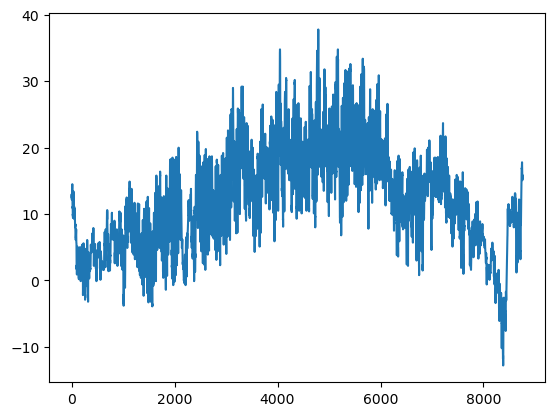

In [2]:
# data imports
data = pd.read_csv("data/Modellierung_SoSe23.csv", sep=";", decimal=",", usecols=[0,1,4])

# load pv_data
pv_data = pd.read_csv("data/ninja_pv_50.8263_6.9721.csv", decimal=".", header=3)

# load and prepare temp data
temp_data = pd.read_csv("data/DWD_wetterdaten_KoelnBonn_Flughafen.txt", sep=";", decimal=".", usecols=[1,3])
temp_data = temp_data[(temp_data['MESS_DATUM'] >= 2022010100) & (temp_data['MESS_DATUM'] < 2023010101)]

# load electricity price data
df_price_data = pd.read_csv("data/Strompreise2019_2022.csv", sep=";", decimal=".", usecols=[2,3,4])
'''
df_price_data["2020_neg"] = df_price_data["2020"].apply(lambda x: 1 if x < 0 else 0)
df_price_data["2020_pos"] = 1 - df_price_data["2020_neg"]
df_price_data["2021_neg"] = df_price_data["2021"].apply(lambda x: 1 if x < 0 else 0)
df_price_data["2021_pos"] = 1 - df_price_data["2021_neg"]
df_price_data["2022_neg"] = df_price_data["2022"].apply(lambda x: 1 if x < 0 else 0)
df_price_data["2022_pos"] = 1 - df_price_data["2022_neg"]
'''

# load loadprofile data
# 2 Inhabitants EFH
el_2p = pd.read_csv('data/loads/2Pers/neighbourhood_el.csv', comment='#', sep=';')
dhw_2p = pd.read_csv('data/loads/2Pers/neighbourhood_dhw.csv', comment='#', sep=';')
htg_2p = pd.read_csv('data/loads/2Pers/neighbourhood_htg.csv', comment='#', sep=';')
# 4 Inhabitants EFH
el_4p = pd.read_csv('data/loads/4Pers/neighbourhood_el.csv', comment='#', sep=';')
dhw_4p = pd.read_csv('data/loads/4Pers/neighbourhood_dhw.csv', comment='#', sep=';')
htg_4p = pd.read_csv('data/loads/4Pers/neighbourhood_htg.csv', comment='#', sep=';')
# 6 Inhabitants EFH
el_6p = pd.read_csv('data/loads/6Pers/neighbourhood_el.csv', comment='#', sep=';')
dhw_6p = pd.read_csv('data/loads/6Pers/neighbourhood_dhw.csv', comment='#', sep=';')
htg_6p = pd.read_csv('data/loads/6Pers/neighbourhood_htg.csv', comment='#', sep=';')

# fill dataframe
df_data = pd.DataFrame()
df_data['pv'] = pv_data['electricity'].to_numpy()
df_data['temp'] = temp_data['TT_TU'].to_numpy()
df_data['ww_load_2p'] = dhw_2p['total']
df_data['ww_load_4p'] = dhw_4p['total']
df_data['ww_load_6p'] = dhw_6p['total']
df_data['e_load_2p'] = el_2p['total']
df_data['e_load_4p'] = el_4p['total']
df_data['e_load_6p'] = el_6p['total']
df_data['h_load_2p'] = htg_2p['total_htg']
df_data['h_load_4p'] = htg_4p['total_htg']
df_data['h_load_6p'] = htg_6p['total_htg']

# season operation of hydrogen system (If PV-power is higher than 0.55 then use ely, fc just in winter months)
df_season = pd.DataFrame()
df_season['ely_pv_threshhold'] = df_data['pv'].apply(lambda x: 1 if x >= 0.55 else 0)
df_season['fc_pv_threshhold'] = 1 - df_season['ely_pv_threshhold']
df_season['ely'] = [1 if 2160 <= x <= 6552 else 0 for x in range(8760)]
df_season['fc'] = 1 - df_season['ely']

df_data['temp'].plot()

In [3]:
# calculation and data preparation for heat_pump(wp)

# scraped data
wp_data = {
    "temp" : [-22, -15, -7, 2, 7, 10, 12, 20, 25, 30, 35],
    "heating_power" : [0, 25.50, 35.20, 43.00, 56.40, 60.30, 62.90, 67.30, 70.40, 73.60, 76.70],
    "el_power" : [0, 14.58, 15.54, 16.70, 18.54, 18.87, 18.87, 19.05, 19.13, 19.36, 19.46],
    "cop" : [0, 1.7, 2.3, 2.6, 3.0, 3.2, 3.3, 3.5, 3.7, 3.8, 3.9]
}

# assumptions
wp_el_p_nom = 12.5  # kW

# calculate COP
df_data["wp_COP_interp"] = np.round(np.interp(df_data['temp'], wp_data["temp"], wp_data["cop"]),3)
df_data["wp_power_consumption"] = np.round(np.interp(df_data['temp'], wp_data["temp"], wp_data["el_power"]),2)
df_data['wp_power_cons_norm'] = df_data["wp_power_consumption"] / wp_el_p_nom

df_data

,pv,temp,ww_load_2p,ww_load_4p,ww_load_6p,e_load_2p,e_load_4p,e_load_6p,h_load_2p,h_load_4p,h_load_6p,wp_COP_interp,wp_power_consumption,wp_power_cons_norm
0,0.0,12.6,0.000000,0.0,1.518594,0.087042,0.108191,0.136886,1.287577,1.274003,1.295842,3.315,18.88,1.5104
1,0.0,13.0,0.000000,0.0,0.000000,0.087303,0.086217,0.135976,1.799948,1.798675,1.809386,3.325,18.89,1.5112
2,0.0,12.6,0.000000,0.0,0.000000,0.086005,0.085922,0.135816,2.128495,2.127315,2.138208,3.315,18.88,1.5104
3,0.0,12.2,0.000000,0.0,0.000000,0.082747,0.109169,0.181411,2.381928,2.364143,2.376183,3.305,18.87,1.5096
4,0.0,12.8,0.000000,0.0,0.000000,0.075984,0.108558,0.179553,2.553156,2.529228,2.542549,3.320,18.89,1.5112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,0.0,15.1,0.000000,0.0,0.000000,0.143545,0.545067,0.574078,1.614701,1.330839,1.452981,3.378,18.94,1.5152
8756,0.0,15.9,0.000000,0.0,0.035994,0.142139,0.228792,1.003943,1.681241,1.550685,1.110155,3.398,18.96,1.5168
8757,0.0,15.9,0.000000,0.0,0.000000,0.142010,0.291029,0.977002,1.713969,1.539984,1.098378,3.398,18.96,1.5168
8758,0.0,15.6,2.712356,0.0,0.971850,0.141723,0.330328,0.473260,1.708129,1.495063,1.420826,3.390,18.95,1.5160


# Parameter- und Variablendefinition

### Komponentenparameter
Für eine leichtere Lesbarkeit und einfachere Zuordnung aller festgelegten Basisparameter, werden Basisdaten in Dictionarys mit eindeutigen Keys definiert

Kapitalkosten: Gesamtsystem spezifisch auf Nennleistung + Angabe der Lifetime(Annahme aller Komponenten mit 20 Jahre)

### Basisvariablen 
Generelle Basisvariablen wie z.B. der Strompreis oder die Gebäudedefinition werden in einfachen globalen Variablen gespeichert

In [4]:
# basicvariables
# cost related variables
electricity_rate = 0.4 # €/kWh
infeed_rate = -0.078    # €/kWh
gas_price = 0.158

# building related variables
living_space = 157 #m²

# grid parameters

# plot parameters
plt.rcParams.update({'font.size': 12})

# data calculations 
# -> here <-------------------!


# component parameters
# PV-plant
pv_params = {
    'p_nom': 10,    # kWp
    'p_max_pu': df_data['pv'],
    'capital_cost': 1750, #€/kWp
    'marginal_cost': 0,
    'lifetime' : 20,
    'pv_co2': 0   #kg/kWh
}

# Picea Home System: https://www.homepowersolutions.de/produkt/
# FuelCell -> fc
fc_params = {
    'p_nom': 1.5, #kW_el Brennstoffzellenleistung picea
    'el_efficiency': 0.6,
    'th_efficiency': 0.3,
    'capital_cost': 21250/1.5,
    'marginal_cost': 0,
    'lifetime' : 20,
}

# Electrolyser -> ely
ely_params = {
    'p_nom': 2.3, #kW_el Wasserstofferzeugungsleistung picea
    'el_efficiency': 0.7,
    'th_efficiency': 0.2,
    'capital_cost': 21250/2.3,
    'marginal_cost': 0,
    'lifetime' : 20,
}

# H2 gas storage
h2_storage_params = {
    'e_nom': 1500, #kWh_el - picea, auf 1500 kWh_el erweiterbar
    'e_nom_min' : 300,
    #'e_min_pu_hydrogen': 0.6,
    #'e_max_pu_hydrogen': 1.0,
    'capital_cost': 21250/300, # € picea system
    'marginal_cost': 0, # Kosten Wasser
    'standing_loss': 0.00001,
    'lifetime' : 20,
    'h2_co2': 0   #kg/kWh
}

# battery storage
battery_picea_params = { # battery integrated in picea system
    'e_nom': 20, #kWh picea system
    'e_nom_min': 10,
    #'e_max_pu': 1.0,
    'capital_cost': 21250/20,
    'marginal_cost': 0,
    'standing_loss': 0.000014,
    'charge_efficiency': 0.98,
    'discharge_efficiency': 0.98,
    'charge_power': 5.7,
    'discharge_power': 5.7,
    'lifetime' : 10
}

# Standard battery: https://greencell.global/de/energie-speichern/4846-green-cell-gc-powernest-energiespeicher-lifepo4-akku-5-kwh-48-v.html#specification
battery_params = {
    'e_nom': 5,
    'e_nom_min': 2,,
    'capital_cost': 2630/5,
    'marginal_cost': 0,
    'standing_loss': 0.000014,
    'charge_efficiency': 0.98,
    'discharge_efficiency': 0.98,
    'charge_power': 5,
    'discharge_power': 5,
    'lifetime' : 10
}


# heatpump -> wp: https://www.viessmann.de/de/wissen/technik-und-systeme/waermepumpe.html
wp_params = {
    'p_nom': 13.2,
    'efficiency': df_data['wp_COP_interp'],
    'capital_cost': 20000/13.2,
    'marginal_cost': 0,
    'lifetime' : 20
}

# heat storage: https://www.viessmann.de/de/produkte/warmwasserbereiter/vitocell-140-e.html
heat_storage_params = {
    'e_nom': 15, #kWh
    'e_nom_min': 5,
    'volume': 300, #Litre
    'capital_cost': 1465/15,
    'marginal_cost': 0,
    'standing_loss': 0.0875,
    'charge_efficiency': 0.95,
    'discharge_efficiency': 0.95,
    'lifetime' : 20
}

# heating rod: https://www.g2-energy-systems.de/elektroheizelemente-heizkoerper/elektroheizelemente/gekapselte-keramikheizpatronen/gekapselte-keramikheizstaebe-mit-flansch-keramische-heizelemente.html
heating_rod_params = {
    'p_nom': 2.2, #kW
    'p_nom_picea': 4.5, #kW
    'efficiency': 1,
    'capital_cost': 210/2.2,
    'capital_cost_picea': 210/4.5,
    'marginal_cost': 0,
    'lifetime' : 20
}

# Gas Boiler: https://www.klimaworld.com/vaillant-brennwerttherme-ecotec-plus-vcw-25-32-cs-1-5-0010043902.html?utm_source=google&utm_medium=cpc&_attribution=GoogleAds&gclid=CjwKCAjw5_GmBhBIEiwA5QSMxLOYbOb4IxBXSJmPPku7bedGxHHWe1i2163OTuT7KkkfBs4bLBmYkBoCTWcQAvD_BwE
gas_boiler_params = {
    'p_nom': 25, #kW
    'efficiency': 1.09,
    'capital_cost': 5650/25,
    'marginal_cost': 5,
    'lifetime' : 20
}


#CO2 emissions
co2_params = {
    'co2_emissions_germany_electricity': 0.434, #kg/kWh (https://de.statista.com/statistik/daten/studie/38897/umfrage/co2-emissionsfaktor-fuer-den-strommix-in-deutschland-seit-1990/#:~:text=Im%20Jahr%202022%20wurde%20der,mit%20kleinen%20Ausnahmen%20kontinuierlich%20ab.)
    'co2_emissions_gas' : 0.202 #kg/kWh (https://www.verbraucherzentrale.de/wissen/energie/heizen-und-warmwasser/klimapaket-was-bedeutet-es-fuer-mieter-und-hausbesitzer-43806)
}

# Funktionsdefinitionen

### Aufbau des Referenznetzwerks
### Aufbau des Wasserstoff Netzwerkes
### Auswertung

In [5]:
def build_ref_network_gas(electric_load=df_data['e_load_2p'], 
                          heat_load=df_data['h_load_2p'],
                          ww_load=df_data['ww_load_2p']):

    # initialyze network
    n_gas = pypsa.Network()
    n_gas.set_snapshots(range(8760))

    # add components
    
    # Carrier
    n_gas.add('Carrier', name = 'grid_electricity',
              co2_emissions = co2_params['co2_emissions_germany_electricity'])
    n_gas.add('Carrier', name = 'gas',
              co2_emissions = co2_params['co2_emissions_gas'])
    n_gas.add('Carrier', name = 'pv_electricity', 
              co2_emissions = pv_params['pv_co2'])
    
    # Buses 
    # electrical buses
    n_gas.add('Bus', name='electricity')
    n_gas.add('Bus', name='bat_bus')    
    # heat buses
    n_gas.add('Bus', name='heat')
    n_gas.add('Bus', name='heat_storage_bus')
    # gas bus
    n_gas.add('Bus', name='gas_bus') 

    # Loads
    # electrical
    n_gas.add('Load', name='electric_load', bus='electricity',
              p_set = electric_load)
    # heat
    n_gas.add('Load', name='heat_load', bus='heat', 
              p_set = heat_load)
    # warm water
    n_gas.add('Load', name='ww_load', bus='heat_storage_bus', 
              p_set = ww_load)

    # Generators
    # PV
    n_gas.add('Generator', name='pv', bus='electricity',
              p_nom = pv_params['p_nom'],
              p_max_pu = pv_params['p_max_pu'],
              capital_cost = pv_params['capital_cost'],
              marginal_cost = pv_params['marginal_cost'],
              lifetime = pv_params['lifetime'],
              carrier='pv_electricity')
    # grid  
    n_gas.add('Generator', name='infeed', bus='electricity',
              marginal_cost = infeed_rate,
              sign = -1, 
              p_nom_extendable = True)
    n_gas.add('Generator', name='grid', bus='electricity',
              marginal_cost = electricity_rate, 
              carrier = 'grid_electricity',
              p_nom_extendable = True)
    # gas
    n_gas.add('Generator', name='gas', bus='gas_bus',
              marginal_cost = gas_price,
              carrier = 'gas',
              p_nom_extendable = True)


    # Storages
    n_gas.add('Store', name='battery',  bus='bat_bus',
              capital_cost = battery_params['capital_cost'], 
              marginal_cost = battery_params['marginal_cost'],
              standing_loss = battery_params['standing_loss'], 
              e_nom_min = battery_params['e_nom_min'],
              lifetime = battery_params['lifetime'],
              e_nom_extendable = True,
              e_cyclic = True)
    n_gas.add('Store', name= 'heat_storage', bus='heat_storage_bus',
              capital_cost = heat_storage_params['capital_cost'], 
              marginal_cost = heat_storage_params['marginal_cost'],
              standing_loss = heat_storage_params['standing_loss'],
              e_nom_min = heat_storage_params['e_nom_min'],
              lifetime = heat_storage_params['lifetime'],
              e_nom_extendable = True,
              e_cyclic = True)


    # Links
    
    n_gas.add('Link', name='charge_bat', bus0='electricity', bus1='bat_bus',
              p_nom = battery_params['charge_power'],
              efficiency = battery_params['charge_efficiency'])
    n_gas.add('Link', name='discharge_bat', bus0='bat_bus', bus1='electricity',
              p_nom = battery_params['discharge_power'],
              efficiency = battery_params['discharge_efficiency'])
              
    n_gas.add('Link', name='gas_boiler', bus0='gas_bus', bus1='heat',
              efficiency = gas_boiler_params['efficiency'],
              capital_cost = gas_boiler_params['capital_cost'],
              marginal_cost = gas_boiler_params['marginal_cost'],
              lifetime = gas_boiler_params['lifetime'],
              carrier = 'gas',
              p_nom_extendable = True)
    
    n_gas.add('Link', name='heating_rod', bus0='electricity', bus1='heat_storage_bus',
              efficiency = heating_rod_params['efficiency'],
              capital_cost = heating_rod_params['capital_cost'],
              marginal_cost = heating_rod_params['marginal_cost'],
              lifetime = heating_rod_params['lifetime'], 
              p_nom_max = heating_rod_params['p_nom'],
              p_nom_extendable = True)
    
    n_gas.add('Link', name='charge_heat', bus0='heat', bus1='heat_storage_bus',
              efficiency = heat_storage_params['charge_efficiency'],
              p_nom_extendable=True,
              p_nom_max = gas_boiler_params["p_nom"])
    n_gas.add('Link', name='discharge_heat', bus0='heat_storage_bus', bus1='heat',
              efficiency = heat_storage_params['discharge_efficiency'],
              p_nom_extendable=True,
              p_nom_max = gas_boiler_params["p_nom"])
    
    # Global Constraints
    n_gas.add('GlobalConstraint', name = 'co2-limit', sense = '<=', 
              carrier_attribute = 'co2_emissions', constant = np.inf)
    
    return n_gas

In [6]:
def build_ref_network(electric_load=df_data['e_load_2p'],
                      heat_load=df_data['h_load_2p'],
                      ww_load=df_data['ww_load_2p']):

    # initialyze network
    n_ref = pypsa.Network()
    n_ref.set_snapshots(range(8760))

    # add components
    
    # Carrier
    n_ref.add('Carrier', name = 'grid_electricity',
              co2_emissions = co2_params['co2_emissions_germany_electricity'])
    n_ref.add('Carrier', name = 'pv_electricity', 
              co2_emissions = pv_params['pv_co2'])
    
    # Buses 
    # electrical buses
    n_ref.add('Bus', name='electricity')
    n_ref.add('Bus', name='bat_bus')    
    # heat buses
    n_ref.add('Bus', name='heat')
    n_ref.add('Bus', name='heat_storage_bus')


    # Loads
    # electrical
    n_ref.add('Load', name='electric_load', bus='electricity',
              p_set = electric_load)
    # heat
    n_ref.add('Load', name='heat_load', bus='heat', 
              p_set = heat_load)
    # warm water
    n_ref.add('Load', name='ww_load', bus='heat_storage_bus', 
              p_set = ww_load)

    # Generators
    # PV
    n_ref.add('Generator', name='pv', bus='electricity',
              p_nom = pv_params['p_nom'],
              p_max_pu = pv_params['p_max_pu'],
              capital_cost = pv_params['capital_cost'],
              marginal_cost = pv_params['marginal_cost'],
              lifetime = pv_params['lifetime'], 
              carrier='pv_electricity')
    # grid  
    n_ref.add('Generator', name='infeed', bus='electricity',
              marginal_cost = infeed_rate,
              sign = -1, 
              p_nom_extendable = True)
    n_ref.add('Generator', name='grid', bus='electricity',
              marginal_cost = electricity_rate, 
              carrier = 'grid_electricity',
              p_nom_extendable = True)


    # Storages
    n_ref.add('Store', name='battery',  bus='bat_bus',
              capital_cost = battery_params['capital_cost'],
              marginal_cost = battery_params['marginal_cost'],  
              standing_loss = battery_params['standing_loss'], 
              e_nom_min = battery_params['e_nom_min'],
              lifetime = battery_params['lifetime'],
              e_nom_extendable = True,
              e_cyclic = True)
    n_ref.add('Store', name= 'heat_storage', bus='heat_storage_bus',
              capital_cost = heat_storage_params['capital_cost'],
              marginal_cost = heat_storage_params['marginal_cost'],
              standing_loss = heat_storage_params['standing_loss'],
              e_nom_min = heat_storage_params['e_nom_min'],
              lifetime = heat_storage_params['lifetime'],
              e_nom_extendable = True,
              e_cyclic = True)


    # Links
    n_ref.add('Link', name='charge_bat', bus0='electricity', bus1='bat_bus',
              p_nom = battery_params['charge_power'],
              efficiency = battery_params['charge_efficiency'])
    n_ref.add('Link', name='discharge_bat', bus0='bat_bus', bus1='electricity',
              p_nom = battery_params['discharge_power'],
              efficiency = battery_params['discharge_efficiency'])
    
    n_ref.add('Link', name='wp', bus0='electricity', bus1='heat',
              efficiency = wp_params['efficiency'],
              capital_cost= wp_params['capital_cost'],
              marginal_cost = wp_params['marginal_cost'],
              lifetime = wp_params['lifetime'],
              p_nom_extendable = True)
    
    n_ref.add('Link', name='charge_heat', bus0='heat', bus1='heat_storage_bus',
              efficiency = heat_storage_params['charge_efficiency'],
              p_nom_extendable=True,
              p_nom_max = wp_params["p_nom"])
    n_ref.add('Link', name='discharge_heat', bus0='heat_storage_bus', bus1='heat',
              efficiency = heat_storage_params['discharge_efficiency'],
              p_nom_extendable=True,
              p_nom_max = wp_params["p_nom"])
    
    # Global Constraints
    n_ref.add('GlobalConstraint', name = 'co2-limit', sense = '<=', 
              carrier_attribute = 'co2_emissions', constant = np.inf)
    
    return n_ref

In [7]:
#n_ref_gas = build_ref_network_gas()

#n_ref_gas.optimize(solver_name='gurobi')
#n_ref_gas.links

In [8]:
#n_ref = build_ref_network()

#n_ref.optimize(solver_name='gurobi')
#n_ref.generators

In [9]:
def build_h2_network_gas(electric_load=df_data['e_load_2p'],
                         heat_load=df_data['h_load_2p'],
                         ww_load=df_data['ww_load_2p']):
    
    # setup Multilinks
    
    override_component_attrs = pypsa.descriptors.Dict(
        {k: v.copy() for k, v in pypsa.components.component_attrs.items()}
    )
    override_component_attrs["Link"].loc["bus2"] = [
        "string",
        np.nan,
        np.nan,
        "2nd bus",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["efficiency2"] = [
        "static or series",
        "per unit",
        0.0,
        "2nd bus efficiency",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["p2"] = [
        "series",
        "MW",
        0.0,
        "2nd bus output",
        "Output",
    ]
    
    
    # initialyze network
    n_h2g = pypsa.Network(override_component_attrs=override_component_attrs)
    #n_h2 = pypsa.Network()
    n_h2g.set_snapshots(range(8760))

    # add components
    
    # Carrier
    n_h2g.add('Carrier', name = 'grid_electricity', 
             co2_emissions = co2_params['co2_emissions_germany_electricity'])
    n_h2g.add('Carrier', name = 'pv_electricity', 
             co2_emissions = pv_params['pv_co2'])
    n_h2g.add('Carrier', name = 'gas',
              co2_emissions = co2_params['co2_emissions_gas'])
    n_h2g.add('Carrier', name = 'h2_electricity', 
             co2_emissions = h2_storage_params['h2_co2'])
    
    # Buses 
    # electrical buses
    n_h2g.add('Bus', name='electricity')
    n_h2g.add('Bus', name='bat_bus')    
    # heat buses
    n_h2g.add('Bus', name='heat')
    n_h2g.add('Bus', name='heat_storage_bus')
    # gas bus
    n_h2g.add('Bus', name='h2_bus', carrier='h2_electricity')
    n_h2g.add('Bus', name='gas_bus') 

    # Loads
    # electrical
    n_h2g.add('Load', name='electric_load', bus='electricity',
              p_set = electric_load)
    # heat
    n_h2g.add('Load', name='heat_load', bus='heat', 
              p_set = heat_load)
    # warm water
    n_h2g.add('Load', name='ww_load', bus='heat_storage_bus', 
              p_set = ww_load)
    
    # Generators
    n_h2g.add('Generator', name='pv', bus='electricity',
             p_nom = pv_params['p_nom'],
             p_max_pu = pv_params['p_max_pu'],
             capital_cost = pv_params['capital_cost'],
             marginal_cost = pv_params['marginal_cost'],
             lifetime = pv_params['lifetime'],
             carrier='pv_electricity')
    # grid
    n_h2g.add('Generator', name='infeed', bus='electricity',
              marginal_cost = infeed_rate,
              sign = -1, 
              p_nom_extendable = True)
    n_h2g.add('Generator', name='grid', bus='electricity', 
              marginal_cost = electricity_rate,
              p_nom_extendable = True,
              carrier = 'grid_electricity')
    # gas grid
    n_h2g.add('Generator', name='gas', bus='gas_bus',
              marginal_cost = gas_price,
              carrier = 'gas',
              p_nom_extendable = True)


    # Storages
    n_h2g.add('Store', name='battery',  bus='bat_bus',
              capital_cost = battery_picea_params['capital_cost'],
              marginal_cost = battery_picea_params['marginal_cost'], 
              standing_loss = battery_picea_params['standing_loss'],
              lifetime = battery_picea_params['lifetime'],
              e_nom = battery_picea_params['e_nom'],
              e_cyclic = True)
    
    n_h2g.add('Store', name= 'heat_storage', bus='heat_storage_bus',
              e_nom = heat_storage_params['e_nom'],
              capital_cost = heat_storage_params['capital_cost'],
              marginal_cost = heat_storage_params['marginal_cost'],
              standing_loss = heat_storage_params['standing_loss'],
              lifetime = heat_storage_params['lifetime'],
              e_cyclic = True)
    n_h2g.add('Store', name='h2_storage', bus='h2_bus',
              capital_cost = h2_storage_params['capital_cost'],
              marginal_cost = h2_storage_params['marginal_cost'],
              standing_loss = h2_storage_params['standing_loss'],
              e_nom_min = h2_storage_params['e_nom_min'],
              lifetime = h2_storage_params['lifetime'],
              e_nom_extendable = True,
              e_cyclic = True)


    # Links
    n_h2g.add('Link', name='charge_bat', bus0='electricity', bus1='bat_bus',
              p_nom = battery_picea_params['charge_power'],
              efficiency = battery_picea_params['charge_efficiency'])
    n_h2g.add('Link', name='discharge_bat', bus0='bat_bus', bus1='electricity',
              p_nom = battery_picea_params['discharge_power'],
              efficiency = battery_picea_params['discharge_efficiency'])
    
    n_h2g.add('Link', name='heating_rod', bus0='electricity', bus1='heat_storage_bus',
              efficiency = heating_rod_params['efficiency'],
              capital_cost = heating_rod_params['capital_cost_picea'],
              marginal_cost = heating_rod_params['marginal_cost'],
              lifetime = heating_rod_params['lifetime'],
              p_nom_max = heating_rod_params['p_nom_picea'],
              p_nom_extendable = True)
    
    n_h2g.add('Link', name='gas_boiler', bus0='gas_bus', bus1='heat',
              efficiency = gas_boiler_params['efficiency'],
              capital_cost = gas_boiler_params['capital_cost'],
              marginal_cost = gas_boiler_params['marginal_cost'],
              lifetime = gas_boiler_params['lifetime'],
              carrier = 'gas',
              p_nom_max = gas_boiler_params['p_nom'],
              p_nom_extendable = True)
    
    n_h2g.add('Link', name='charge_heat', bus0='heat', bus1='heat_storage_bus',
              efficiency = heat_storage_params['charge_efficiency'],
              p_nom_extendable=True,
              p_nom_max = heating_rod_params["p_nom_picea"])
    n_h2g.add('Link', name='discharge_heat', bus0='heat_storage_bus', bus1='heat',
              efficiency = heat_storage_params['discharge_efficiency'],
              p_nom_extendable=True,
              p_nom_max = heating_rod_params["p_nom_picea"])

    
    # Multilinks
    # electrolysis
    n_h2g.add('Link', name='ely', bus0='electricity', bus1='h2_bus', bus2='heat', 
             efficiency = ely_params['el_efficiency'], efficiency2 = ely_params['th_efficiency'],
             capital_cost = ely_params['capital_cost'],
             marginal_cost = ely_params['marginal_cost'],
             p_nom = ely_params['p_nom'],
             p_max_pu = df_season['ely_pv_threshhold'],
             lifetime = ely_params['lifetime'],
             carrier='h2_electricity')
    # fuellcell
    n_h2g.add('Link', name='fc', bus0='h2_bus', bus1='electricity', bus2='heat',
             efficiency = fc_params['el_efficiency'], efficiency2 = fc_params['th_efficiency'],
             capital_cost = fc_params['capital_cost'],
             marginal_cost = fc_params['marginal_cost'],
             p_nom = fc_params['p_nom'],
             p_max_pu = df_season['fc'],
             lifetime = fc_params['lifetime'],
             carrier='h2_electricity')
    '''
    
    # electrolysis
    n_h2g.add('Link', name='ely1', bus0='electricity', bus1='h2_bus',
             efficiency = ely_params['el_efficiency'],
             capital_cost = ely_params['capital_cost'],
             p_nom_extendable = True,
             carrier = 'h2_electricity')
    
    n_h2g.add('Link', name='ely2', bus0='electricity', bus1='heat',
             efficiency = ely_params['th_efficiency'],
             capital_cost = ely_params['capital_cost'],
             p_nom_extendable = True,
             carrier = 'h2_electricity')
    
    # fuellcell
    n_h2g.add('Link', name='fc1', bus0='h2_bus', bus1='electricity',
             efficiency = fc_params['el_efficiency'],
             capital_cost = fc_params['capital_cost'],
             p_nom_extendable = True,
             carrier = 'h2_electricity')
    
    n_h2g.add('Link', name='fc2', bus0='h2_bus', bus1='heat',
             efficiency = fc_params['th_efficiency'],
             capital_cost = fc_params['capital_cost'],
             p_nom_extendable = True,
             carrier = 'h2_electricity')
    '''
    
    # Global Constraints
    n_h2g.add('GlobalConstraint', name = 'co2-limit', sense = '<=', 
            carrier_attribute = 'co2_emissions', constant = np.inf)
    return n_h2g

In [10]:
def build_h2_network(electric_load=df_data['e_load_2p'], 
                     heat_load=df_data['h_load_2p'],
                     ww_load=df_data['ww_load_2p']):
    
    # setup Multilinks
    
    override_component_attrs = pypsa.descriptors.Dict(
        {k: v.copy() for k, v in pypsa.components.component_attrs.items()}
    )
    override_component_attrs["Link"].loc["bus2"] = [
        "string",
        np.nan,
        np.nan,
        "2nd bus",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["efficiency2"] = [
        "static or series",
        "per unit",
        0.0,
        "2nd bus efficiency",
        "Input (optional)",
    ]
    override_component_attrs["Link"].loc["p2"] = [
        "series",
        "MW",
        0.0,
        "2nd bus output",
        "Output",
    ]
    
    
    # initialyze network
    n_h2 = pypsa.Network(override_component_attrs=override_component_attrs)
    #n_h2 = pypsa.Network()
    n_h2.set_snapshots(range(8760))

    # add components
    
    # Carrier
    
    n_h2.add('Carrier', name = 'grid_electricity', 
             co2_emissions = co2_params['co2_emissions_germany_electricity'])
    n_h2.add('Carrier', name = 'pv_electricity', 
             co2_emissions = pv_params['pv_co2'])
    n_h2.add('Carrier', name = 'h2_electricity', 
             co2_emissions = h2_storage_params['h2_co2'])
    # Buses 
    # electrical buses
    n_h2.add('Bus', name='electricity')
    n_h2.add('Bus', name='bat_bus')    
    #n_h2.add('Bus', name='house_IO')   # Überschussknoten -> Haus In- und Output
    # heat buses
    n_h2.add('Bus', name='heat')
    n_h2.add('Bus', name='heat_storage_bus')
    # gas bus
    n_h2.add('Bus', name='h2_bus', carrier='h2_electricity')

    # Loads
    # electrical
    n_h2.add('Load', name='electric_load', bus='electricity',
             p_set = electric_load)
    # heat
    n_h2.add('Load', name='heat_load', bus='heat', 
             p_set = heat_load)
    # warm water
    n_h2.add('Load', name='ww_load', bus='heat_storage_bus', 
             p_set = ww_load)

    # Generators
    # PV -> Wie viel PV müsste man zubauen? evtl. Berücksichtigen???
    n_h2.add('Generator', name='pv', bus='electricity',
             p_nom = pv_params['p_nom'],
             p_max_pu = pv_params['p_max_pu'],
             capital_cost = pv_params['capital_cost'],
             marginal_cost = pv_params['marginal_cost'],
             lifetime = pv_params['lifetime'],
             carrier='pv_electricity')
    # grid
    n_h2.add('Generator', name='infeed', bus='electricity',
             marginal_cost = infeed_rate,
             sign = -1, 
             p_nom_extendable = True)
    n_h2.add('Generator', name='grid', bus='electricity', 
             marginal_cost = electricity_rate,
             p_nom_extendable = True,
             carrier = 'grid_electricity')


    # Storages
    n_h2.add('Store', name='battery',  bus='bat_bus',
             capital_cost = battery_picea_params['capital_cost'],
             marginal_cost = battery_picea_params['marginal_cost'], 
             standing_loss = battery_picea_params['standing_loss'],
             lifetime = battery_picea_params['lifetime'],
             e_nom = battery_picea_params['e_nom'],
             e_cyclic = True)
    n_h2.add('Store', name= 'heat_storage', bus='heat_storage_bus',
             e_nom = heat_storage_params['e_nom'],
             capital_cost = heat_storage_params['capital_cost'],
             marginal_cost = heat_storage_params['marginal_cost'],
             standing_loss = heat_storage_params['standing_loss'],
             lifetime = heat_storage_params['lifetime'],
             e_cyclic = True)
    n_h2.add('Store', name='h2_storage', bus='h2_bus',
             capital_cost = h2_storage_params['capital_cost'],
             marginal_cost = h2_storage_params['marginal_cost'],
             standing_loss = h2_storage_params['standing_loss'],
             e_nom_min = h2_storage_params['e_nom_min'],
             lifetime = h2_storage_params['lifetime'],
             e_nom_extendable = True,
             e_cyclic = True)


    # Links
    n_h2.add('Link', name='charge_bat', bus0='electricity', bus1='bat_bus',
              p_nom = battery_picea_params['charge_power'],
              efficiency = battery_picea_params['charge_efficiency'])
    n_h2.add('Link', name='discharge_bat', bus0='bat_bus', bus1='electricity',
              p_nom = battery_picea_params['discharge_power'],
              efficiency = battery_picea_params['discharge_efficiency'])
    
    n_h2.add('Link', name='wp', bus0='electricity', bus1='heat',
             efficiency = wp_params['efficiency'],
             capital_cost = wp_params['capital_cost'],
             marginal_cost = wp_params['marginal_cost'],
             lifetime = wp_params['lifetime'],
             p_nom = wp_params['p_nom'])
    
    n_h2.add('Link', name='charge_heat', bus0='heat', bus1='heat_storage_bus',
              efficiency = heat_storage_params['charge_efficiency'],
              p_nom_extendable=True,
              p_nom_max = wp_params["p_nom"])
    n_h2.add('Link', name='discharge_heat', bus0='heat_storage_bus', bus1='heat',
              efficiency = heat_storage_params['discharge_efficiency'],
              p_nom_extendable=True,
              p_nom_max = wp_params["p_nom"])

    
    # Multilinks
    # electrolysis
    n_h2.add('Link', name='ely', bus0='electricity', bus1='h2_bus', bus2='heat', 
             efficiency = ely_params['el_efficiency'], efficiency2 = ely_params['th_efficiency'],
             capital_cost = ely_params['capital_cost'],
             marginal_cost = ely_params['marginal_cost'],
             p_nom = ely_params['p_nom'],
             p_max_pu = df_season['ely_pv_threshhold'],
             lifetime = ely_params['lifetime'],
             carrier='h2_electricity')
    # fuellcell
    n_h2.add('Link', name='fc', bus0='h2_bus', bus1='electricity', bus2='heat',
             efficiency = fc_params['el_efficiency'], efficiency2 = fc_params['th_efficiency'],
             capital_cost = fc_params['capital_cost'],
             marginal_cost = fc_params['marginal_cost'],
             p_nom = fc_params['p_nom'],
             p_max_pu = df_season['fc'],
             lifetime = fc_params['lifetime'],
             carrier='h2_electricity')
    '''
    
    # electrolysis
    n_h2.add('Link', name='ely1', bus0='electricity', bus1='h2_bus',
             efficiency = ely_params['el_efficiency'],
             capital_cost = ely_params['capital_cost'],
             p_nom_extendable = True,
             carrier = 'h2_electricity')
    
    n_h2.add('Link', name='ely2', bus0='electricity', bus1='heat',
             efficiency = ely_params['th_efficiency'],
             capital_cost = ely_params['capital_cost'],
             p_nom_extendable = True,
             carrier = 'h2_electricity')
    
    # fuellcell
    n_h2.add('Link', name='fc1', bus0='h2_bus', bus1='electricity',
             efficiency = fc_params['el_efficiency'],
             capital_cost = fc_params['capital_cost'],
             p_nom_extendable = True,
             carrier = 'h2_electricity')
    
    n_h2.add('Link', name='fc2', bus0='h2_bus', bus1='heat',
             efficiency = fc_params['th_efficiency'],
             capital_cost = fc_params['capital_cost'],
             p_nom_extendable = True,
             carrier = 'h2_electricity')
    '''
    
    # Global Constraints
    n_h2.add('GlobalConstraint', name = 'co2-limit', sense = '<=', 
            carrier_attribute = 'co2_emissions', constant = np.inf)
    return n_h2

In [11]:
#n_h2_gas = build_h2_network_gas()

#n_h2_gas.optimize(solver_name='gurobi')


In [12]:
#n_h2 = build_h2_network()

#n_h2.optimize(solver_name='gurobi')

In [13]:
def auswertungsfunktion(network, sensitivity_variable=0, co2_constraint=0):
    #Funktion der laufenden kosten
    if network == n_h2:
        
        #co2 Calculation
        co2 = (network.generators_t.p.sum() / network.generators.efficiency * 
               pd.merge(network.carriers, network.generators.carrier, 
                        left_index = True, 
                        right_on = 'carrier')['co2_emissions']).sum()
        
        #Funktion der laufende Kosten
        laufende_kosten_generators = (network.generators_t.p.grid * network.generators.marginal_cost.grid).sum()
        #Funktion für Investitionskosten
        #kapital_kosten_generators = (network.generators.p_nom_opt * network.generators.capital_cost).sum()      #nimmt hier auch Netzeinspeisung und Netzbezug mit rein
        kapital_kosten_generators = (network.generators.p_nom_opt.pv * network.generators.capital_cost.pv).sum()
        kapital_kosten_links = (network.links.p_nom_opt * network.links.capital_cost).sum()
        kapital_kosten_stores = (network.stores.e_nom_opt *network.stores.capital_cost).sum()
        kapital_kosten_gesamt = (kapital_kosten_stores + kapital_kosten_generators + kapital_kosten_links )

        #Gesamtkosten pro Jahr
        total_kosten = (laufende_kosten_generators + kapital_kosten_generators 
        + kapital_kosten_stores + kapital_kosten_links) 


        #Einspeisevergütung (separat betrachtet von Gesamtkosten)
        einspeise_ertrag = 0


        #Jährliche Einsparung der marginalen Kosten
        bezug_ursprung = (network.loads_t.p.electric_load * network.generators.marginal_cost.grid +
                          network.loads_t.p.heat_load * gas_price).sum()
        einsparung = bezug_ursprung - laufende_kosten_generators 

        #Armotisation
        Anschaffungskosten = (kapital_kosten_generators *20) + (kapital_kosten_links *20) +(kapital_kosten_stores * 20) #+ (kapital_kosten_links *20)   # kapital_kosten_links doppelt in Rechnung
        Amortisation = Anschaffungskosten/einsparung 


        #relevante Ausgabewerte
        netzbezug_summe = (network.generators_t.p.grid).sum()
        netzeinspeisung_summe= 0
        pv_ertrag_summe = (network.generators_t.p.pv).sum()
        einspeicherung_summe = (network.links_t.p0.charge_bat).sum()
        ausspeicherung_summe = (network.links_t.p0.discharge_bat).sum()
        Kapazität_Batterie = (network.stores.e_nom_opt.battery)
        Kapazität_Pufferspeicher =(network.stores.e_nom_opt.heat_storage)#*36.85)
        Leistung_wp = (network.links.p_nom_opt.wp)



        #Werte in Ergebnistabelle auflisten
        df_result = pd.concat([pd.DataFrame(data=co2, index=[sensitivity_variable], columns=['CO2_emissions in kg/a']),
                               pd.DataFrame(data=total_kosten, index=[sensitivity_variable], columns=['Kapital- und marginale kosten €/a']),
                               pd.DataFrame(data=einsparung, index=[sensitivity_variable], columns=['Verbrauchseinsparung €/a']),
                               pd.DataFrame(data=laufende_kosten_generators, index=[sensitivity_variable], columns=['Marginale Kosten €/a']),
                               pd.DataFrame(data=bezug_ursprung, index=[sensitivity_variable], columns=['Ursprüngliche Energiekosten €/a']),
                               pd.DataFrame(data=kapital_kosten_gesamt, index=[sensitivity_variable], columns=['Investitionskosten €/a']),
                               pd.DataFrame(data=einspeise_ertrag, index=[sensitivity_variable], columns=['Einspeiseverguetung €/a']),
                               pd.DataFrame(data=Amortisation, index=[sensitivity_variable], columns=['Amortisationsdauer a']),
                               pd.DataFrame(data=netzbezug_summe, index=[sensitivity_variable], columns=['Netzbezug kWh/a']),
                               pd.DataFrame(data=netzeinspeisung_summe, index=[sensitivity_variable], columns=['Netzeinspeisung kWh/a']),
                               pd.DataFrame(data=pv_ertrag_summe, index=[sensitivity_variable], columns=['PV-Ertragssumme kWh/a']),
                               pd.DataFrame(data=einspeicherung_summe, index=[sensitivity_variable], columns=['Einspeicherung kWh/a']),
                               pd.DataFrame(data=ausspeicherung_summe, index=[sensitivity_variable], columns=['Auspeicherung kWh/a']),
                               pd.DataFrame(data=Kapazität_Pufferspeicher, index=[sensitivity_variable], columns=['Pufferspeicherkapazität kWh']),
                               pd.DataFrame(data=Kapazität_Batterie, index=[sensitivity_variable], columns=['Batteriepeicherkapazität kWh']),
                               pd.DataFrame(data=Leistung_wp, index=[sensitivity_variable], columns=['Leistung Wärmepumpe kW']),],
                               axis = 1)
    else:
       
        #co2 Calculation
        co2 = (network.generators_t.p.sum() / network.generators.efficiency * 
               pd.merge(network.carriers, network.generators.carrier, 
                        left_index = True, 
                        right_on = 'carrier')['co2_emissions']).sum()
       
        #Funktion der laufende Kosten 
        laufende_kosten_generators = (network.generators_t.p.grid * network.generators.marginal_cost.grid + 
                                      network.generators_t.p.infeed * network.generators.marginal_cost.infeed).sum()
        
        #Funktion für Investitionskosten
        #kapital_kosten_generators = (network.generators.p_nom_opt * network.generators.capital_cost).sum()      #nimmt hier auch Netzeinspeisung und Netzbezug mit rein
        kapital_kosten_generators = (network.generators.p_nom_opt.pv * network.generators.capital_cost.pv).sum()
        kapital_kosten_links = (network.links.p_nom_opt * network.links.capital_cost).sum()
        kapital_kosten_stores = (network.stores.e_nom_opt *network.stores.capital_cost).sum()
        kapital_kosten_gesamt = (kapital_kosten_stores + kapital_kosten_generators + kapital_kosten_links )

        #Gesamtkosten pro Jahr
        total_kosten = (laufende_kosten_generators + kapital_kosten_generators 
        + kapital_kosten_stores + kapital_kosten_links) 


        #Einspeisevergütung (separat betrachtet von Gesamtkosten)
        einspeise_ertrag = (network.generators_t.p.infeed).sum()*electricity_rate *-1


        #Jährliche Einsparung der marginalen Kosten
        bezug_ursprung = (network.loads_t.p.electric_load * network.generators.marginal_cost.grid +
                          network.loads_t.p.heat_load * gas_price).sum()
        einsparung = bezug_ursprung - laufende_kosten_generators 

        #Armotisation
        Anschaffungskosten = (kapital_kosten_generators *20) + (kapital_kosten_links *20) +(kapital_kosten_stores * 20) #+ (kapital_kosten_links *20)   # kapital_kosten_links doppelt in Rechnung
        Amortisation = Anschaffungskosten/einsparung 


        #relevante Ausgabewerte
        netzbezug_summe = (network.generators_t.p.grid).sum()
        netzeinspeisung_summe= (network.generators_t.p.infeed).sum()
        pv_ertrag_summe = (network.generators_t.p.pv).sum()
        einspeicherung_summe = (network.links_t.p0.charge_bat).sum()
        ausspeicherung_summe = (network.links_t.p0.discharge_bat).sum()
        Kapazität_Batterie = (network.stores.e_nom_opt.battery)
        Kapazität_Pufferspeicher =(network.stores.e_nom_opt.heat_storage)#*36.85)
        Leistung_wp = (network.links.p_nom_opt.wp)



        #Werte in Ergebnistabelle auflisten
        df_result = pd.concat([pd.DataFrame(data=co2, index=[sensitivity_variable], columns=['CO2_emissions in kg/a']),
                               pd.DataFrame(data=total_kosten, index=[sensitivity_variable],columns=['Kapital- und marginale kosten €/a']),
                               pd.DataFrame(data=einsparung, index=[sensitivity_variable], columns=['Verbrauchseinsparung €/a']),
                               pd.DataFrame(data=laufende_kosten_generators, index=[sensitivity_variable], columns=['Marginale Kosten €/a']),
                               pd.DataFrame(data=bezug_ursprung, index=[sensitivity_variable], columns=['Ursprüngliche Energiekosten €/a']),
                               pd.DataFrame(data=kapital_kosten_gesamt, index=[sensitivity_variable], columns=['Investitionskosten €/a']),
                               pd.DataFrame(data=einspeise_ertrag, index=[sensitivity_variable], columns=['Einspeiseverguetung €/a']),
                               pd.DataFrame(data=Amortisation, index=[sensitivity_variable], columns=['Amortisationsdauer a']),
                               pd.DataFrame(data=netzbezug_summe, index=[sensitivity_variable], columns=['Netzbezug kWh/a']),
                               pd.DataFrame(data=netzeinspeisung_summe, index=[sensitivity_variable], columns=['Netzeinspeisung kWh/a']),
                               pd.DataFrame(data=pv_ertrag_summe, index=[sensitivity_variable], columns=['PV-Ertragssumme kWh/a']),
                               pd.DataFrame(data=einspeicherung_summe, index=[sensitivity_variable], columns=['Einspeicherung kWh/a']),
                               pd.DataFrame(data=ausspeicherung_summe, index=[sensitivity_variable], columns=['Auspeicherung kWh/a']),
                               pd.DataFrame(data=Kapazität_Pufferspeicher, index=[sensitivity_variable], columns=['Pufferspeicherkapazität kWh']),
                               pd.DataFrame(data=Kapazität_Batterie, index=[sensitivity_variable], columns=['Batteriepeicherkapazität kWh']),
                               pd.DataFrame(data=Leistung_wp, index=[sensitivity_variable], columns=['Leistung Wärmepumpe kW']),],
                               axis = 1)

    return df_result

In [14]:
def opt_series_summary(network, h2=False, h2_gas=False, ref_gas=False, ref=False):

    date_index = pd.date_range(start='2022-01-01 00:00', end='2022-12-31 23:00', freq='H')
    
    co2 = (network.generators_t.p.sum() / network.generators.efficiency * 
               pd.merge(network.carriers, network.generators.carrier, 
                        left_index = True, 
                        right_on = 'carrier')['co2_emissions']).sum()
    print("CO2-Emissionen: ", co2)
    
    if h2 == True:
        df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(), index=date_index, columns=['Grid']),
                                   pd.DataFrame(data=network.generators_t.p.pv.to_numpy(), index=date_index, columns=['PV']),
                                   pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(), index=date_index, columns=['Einspeisung']),
                                   pd.DataFrame(data=network.links_t.p0.wp.to_numpy(), index=date_index, columns=['WP']),
                                   pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(), index=date_index, columns=['Electric Load']),
                                   pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(), index=date_index, columns=['Heat load']),
                                   pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(), index=date_index, columns=['WW load']),
                                   pd.DataFrame(data=network.stores_t.e.h2_storage.to_numpy(), index=date_index, columns=['H2 Storage']),
                                   pd.DataFrame(data=network.links_t.p0.fc.to_numpy(), index=date_index, columns=['Fuel Cell']),
                                   pd.DataFrame(data=network.links_t.p0.ely.to_numpy(), index=date_index, columns=['Electrolysis']),
                                   pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(), index=date_index, columns=['Battery IN']),
                                   pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(), index=date_index, columns=['Battery OUT']),
                                   pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(), index=date_index, columns=['Heatstore IN']),
                                   pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(), index=date_index, columns=['Heatstore OUT']), 
                                   pd.DataFrame(data=network.stores_t.e.battery.to_numpy(), index=date_index, columns=['Battery']),
                                   pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(), index=date_index, columns=['Heat Storage']),],
                                   axis = 1)
    elif h2_gas == True:
        df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(), index=date_index, columns=['Grid']),
                                   pd.DataFrame(data=network.generators_t.p.gas.to_numpy(), index=date_index, columns=['Gas Grid']),
                                   pd.DataFrame(data=network.generators_t.p.pv.to_numpy(), index=date_index, columns=['PV']),
                                   pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(), index=date_index, columns=['Einspeisung']),
                                   pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(), index=date_index, columns=['Electric Load']),
                                   pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(), index=date_index, columns=['Heat load']),
                                   pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(), index=date_index, columns=['WW load']),
                                   pd.DataFrame(data=network.links_t.p0.heating_rod.to_numpy(), index=date_index, columns=['Heating Rod']),
                                   pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(), index=date_index, columns=['Battery IN']),
                                   pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(), index=date_index, columns=['Battery OUT']),
                                   pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(), index=date_index, columns=['Heatstore IN']),
                                   pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(), index=date_index, columns=['Heatstore OUT']), 
                                   pd.DataFrame(data=network.stores_t.e.battery.to_numpy(), index=date_index, columns=['Battery']),
                                   pd.DataFrame(data=network.links_t.p0.gas_boiler.to_numpy(), index=date_index, columns=['Boiler']),
                                   pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(), index=date_index, columns=['Heat Storage']),
                                   pd.DataFrame(data=network.stores_t.e.h2_storage.to_numpy(), index=date_index, columns=['H2 Storage']),
                                   pd.DataFrame(data=network.links_t.p0.fc.to_numpy(), index=date_index, columns=['Fuel Cell']),
                                   pd.DataFrame(data=network.links_t.p0.ely.to_numpy(), index=date_index, columns=['Electrolysis'])],
                                   axis = 1)
    elif ref_gas == True:
        df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(), index=date_index, columns=['Grid']),
                                   pd.DataFrame(data=network.generators_t.p.gas.to_numpy(), index=date_index, columns=['Gas Grid']),
                                   pd.DataFrame(data=network.generators_t.p.pv.to_numpy(), index=date_index, columns=['PV']),
                                   pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(), index=date_index, columns=['Einspeisung']),
                                   pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(), index=date_index, columns=['Electric Load']),
                                   pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(), index=date_index, columns=['Heat load']),
                                   pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(), index=date_index, columns=['WW load']),
                                   pd.DataFrame(data=network.links_t.p0.heating_rod.to_numpy(), index=date_index, columns=['Heating Rod']),
                                   pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(), index=date_index, columns=['Battery IN']),
                                   pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(), index=date_index, columns=['Battery OUT']),
                                   pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(), index=date_index, columns=['Heatstore IN']),
                                   pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(), index=date_index, columns=['Heatstore OUT']),
                                   pd.DataFrame(data=network.stores_t.e.battery.to_numpy(), index=date_index, columns=['Battery']),
                                   pd.DataFrame(data=network.links_t.p0.gas_boiler.to_numpy(), index=date_index, columns=['Boiler']),
                                   pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(), index=date_index, columns=['Heat Storage'])],
                                   axis = 1)
    elif ref == True:
        df_res_series = pd.concat([pd.DataFrame(data=network.generators_t.p.grid.to_numpy(), index=date_index, columns=['Grid']),
                                   pd.DataFrame(data=network.generators_t.p.pv.to_numpy(), index=date_index, columns=['PV']),
                                   pd.DataFrame(data=network.generators_t.p.infeed.to_numpy(), index=date_index, columns=['Einspeisung']),
                                   pd.DataFrame(data=network.links_t.p0.wp.to_numpy(), index=date_index, columns=['WP']),
                                   pd.DataFrame(data=network.loads_t.p.electric_load.to_numpy(), index=date_index, columns=['Electric Load']),
                                   pd.DataFrame(data=network.loads_t.p.heat_load.to_numpy(), index=date_index, columns=['Heat load']),
                                   pd.DataFrame(data=network.loads_t.p.ww_load.to_numpy(), index=date_index, columns=['WW load']),
                                   pd.DataFrame(data=network.stores_t.e.battery.to_numpy(), index=date_index, columns=['Battery']),
                                   pd.DataFrame(data=network.links_t.p0.charge_heat.to_numpy(), index=date_index, columns=['Heatstore IN']),
                                   pd.DataFrame(data=network.links_t.p0.discharge_heat.to_numpy(), index=date_index, columns=['Heatstore OUT']),
                                   pd.DataFrame(data=network.links_t.p0.charge_bat.to_numpy(), index=date_index, columns=['Battery IN']),
                                   pd.DataFrame(data=network.links_t.p0.discharge_bat.to_numpy(), index=date_index, columns=['Battery OUT']),
                                   pd.DataFrame(data=network.stores_t.e.heat_storage.to_numpy(), index=date_index, columns=['Heat Storage'])],
                                   axis = 1)
    else:
        print("zutreffendes Netzwerk für die Datenzusammenstellung auf (=True) setzen")
            
    
    return df_res_series

In [15]:
def opt_value_summary(n1=None, n2=None, n3=None, n4=None, n12=False, n34=False, n_all=False):
    '''
    This Method sums up all optimized values for power and capacity
    n1 = Referenznetzwerk Gas
    n2 = H2-Netzwerk Gas
    n3 = Referenznetzwerk EE
    n4 = H2-Netzwerk EE
    '''
    if n12 == True: # compare Gas Networks
        df1 = pd.concat([pd.DataFrame(data=n1.generators.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n1.generators.p_nom_opt.index, columns=['Ref Gas']),
                         pd.DataFrame(data=n1.stores.e_nom_opt.to_numpy().round(decimals=2),
                                      index=n1.stores.e_nom_opt.index, columns=['Ref Gas']),
                         pd.DataFrame(data=n1.links.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n1.links.p_nom_opt.index, columns=["Ref Gas"])], axis=0)
        df2 = pd.concat([pd.DataFrame(data=n2.generators.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n2.generators.p_nom_opt.index, columns=['H2 Gas']),
                         pd.DataFrame(data=n2.stores.e_nom_opt.to_numpy().round(decimals=2),
                                      index=n2.stores.e_nom_opt.index, columns=['H2 Gas']),
                         pd.DataFrame(data=n2.links.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n2.links.p_nom_opt.index, columns=["H2 Gas"])], axis=0)
        df_opt_values = pd.concat([df1, df2], axis=1, join='outer')
        
    elif n34 == True: # compare EE Networks
        df3 = pd.concat([pd.DataFrame(data=n3.generators.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n3.generators.p_nom_opt.index, columns=['Ref EE']),
                         pd.DataFrame(data=n3.stores.e_nom_opt.to_numpy().round(decimals=2),
                                      index=n3.stores.e_nom_opt.index, columns=['Ref EE']),
                         pd.DataFrame(data=n3.links.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n3.links.p_nom_opt.index, columns=["Ref EE"])], axis=0)
        df4 = pd.concat([pd.DataFrame(data=n4.generators.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n4.generators.p_nom_opt.index, columns=['H2 EE']),
                         pd.DataFrame(data=n4.stores.e_nom_opt.to_numpy().round(decimals=2),
                                      index=n4.stores.e_nom_opt.index, columns=['H2 EE']),
                         pd.DataFrame(data=n4.links.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n4.links.p_nom_opt.index, columns=["H2 EE"])], axis=0)
        df_opt_values = pd.concat([df3, df4], axis=1, join='outer')
        
    elif n_all == True: # compare all Networks
        df1 = pd.concat([pd.DataFrame(data=n1.generators.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n1.generators.p_nom_opt.index, columns=['Ref Gas']),
                         pd.DataFrame(data=n1.stores.e_nom_opt.to_numpy().round(decimals=2),
                                      index=n1.stores.e_nom_opt.index, columns=['Ref Gas']),
                         pd.DataFrame(data=n1.links.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n1.links.p_nom_opt.index, columns=["Ref Gas"])], axis=0)
        df2 = pd.concat([pd.DataFrame(data=n2.generators.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n2.generators.p_nom_opt.index, columns=['H2 Gas']),
                         pd.DataFrame(data=n2.stores.e_nom_opt.to_numpy().round(decimals=2),
                                      index=n2.stores.e_nom_opt.index, columns=['H2 Gas']),
                         pd.DataFrame(data=n2.links.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n2.links.p_nom_opt.index, columns=["H2 Gas"])], axis=0)
        df3 = pd.concat([pd.DataFrame(data=n3.generators.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n3.generators.p_nom_opt.index, columns=['Ref EE']),
                         pd.DataFrame(data=n3.stores.e_nom_opt.to_numpy().round(decimals=2),
                                      index=n3.stores.e_nom_opt.index, columns=['Ref EE']),
                         pd.DataFrame(data=n3.links.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n3.links.p_nom_opt.index, columns=["Ref EE"])], axis=0)
        df4 = pd.concat([pd.DataFrame(data=n4.generators.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n4.generators.p_nom_opt.index, columns=['H2 EE']),
                         pd.DataFrame(data=n4.stores.e_nom_opt.to_numpy().round(decimals=2),
                                      index=n4.stores.e_nom_opt.index, columns=['H2 EE']),
                         pd.DataFrame(data=n4.links.p_nom_opt.to_numpy().round(decimals=2), 
                                      index=n4.links.p_nom_opt.index, columns=["H2 EE"])], axis=0)
        df_opt_values = pd.concat([df1, df2, df3, df4], axis=1, join='outer')
        
    else:
        print("zutreffende Netzwerk-Kombination(n12, n34, n_all) für die Datenzusammenstellung auf (=True) setzen")
    
    return df_opt_values

In [16]:
def calc_global_results(n1=None, n2=None, n3=None, n4=None, n12=False, n34=False, n_all=False):
    '''
    This Method calculates results of each network and additionally combined results
    n1 = Referenznetzwerk Gas
    n2 = H2-Netzwerk Gas
    n3 = Referenznetzwerk EE
    n4 = H2-Netzwerk EE
    '''
    df_global_results = pd.DataFrame()
    
    # calculate result information
    if n12 == True: # compare Gas Networks
        
        
        # grid supply
        grid_supply1 = n1.generators_t.p.grid.sum() + n1.generators_t.p.gas.sum()
        grid_supply2 = n2.generators_t.p.grid.sum() + n2.generators_t.p.gas.sum()
        # loads
        load1 = n1.loads_t.p.electric_load.sum() + n1.loads_t.p.heat_load.sum() + n1.loads_t.p.ww_load.sum()
        load2 = n2.loads_t.p.electric_load.sum() + n2.loads_t.p.heat_load.sum() + n2.loads_t.p.ww_load.sum()
        # autarchy
        aut1 = np.round(((load1 - grid_supply1) / load1)*100, 2)
        aut2 = np.round(((load2 - grid_supply2) / load2)*100, 2)
        # co2 emissions
        co2_1 = (n1.generators_t.p.sum() / n1.generators.efficiency *
                 pd.merge(n1.carriers, n1.generators.carrier, 
                          left_index = True, 
                          right_on = 'carrier')['co2_emissions']).sum()
        co2_2 = (n2.generators_t.p.sum() / n2.generators.efficiency *
                 pd.merge(n2.carriers, n2.generators.carrier, 
                          left_index = True, 
                          right_on = 'carrier')['co2_emissions']).sum()
        
        # capital cost system
        # n1
        capex_stores1 = (n1.stores.e_nom_opt * n1.stores.capital_cost).sum()
        capex_gen1 = (n1.generators.p_nom_opt * n1.generators.capital_cost).sum()
        capex_links1 = (n1.links.p_nom_opt * n1.links.capital_cost).sum()
        capex1 = capex_stores1 + capex_gen1 + capex_links1
        # n2
        capex_stores2 = (n2.stores.e_nom_opt * n2.stores.capital_cost).sum()
        capex_gen2 = (n2.generators.p_nom_opt * n2.generators.capital_cost).sum()
        capex_links2 = (n2.links.p_nom_opt * n2.links.capital_cost).sum()
        capex2 = capex_stores2 + capex_gen2 + capex_links2
        
        # marginal cost system
        # n1
        try:
            opex1 = ((n1.generators_t.p.grid * n1.generators_t.marginal_cost.grid).sum() 
                     + (n1.generators_t.p.gas * n1.generators.marginal_cost.gas).sum()
                     + (n1.generators_t.p.pv * n1.generators.marginal_cost.pv).sum() 
                     + (n1.stores_t.e * n1.stores.marginal_cost).sum().sum()  
                     + (n1.links_t.p0 * n1.links.marginal_cost).sum().sum())
        except:
            opex1 = ((n1.generators_t.p.grid * n1.generators.marginal_cost.grid).sum() 
                     + (n1.generators_t.p.gas * n1.generators.marginal_cost.gas).sum()
                     + (n1.generators_t.p.pv * n1.generators.marginal_cost.pv).sum() 
                     + (n1.stores_t.e * n1.stores.marginal_cost).sum().sum()  
                     + (n1.links_t.p0 * n1.links.marginal_cost).sum().sum())
        # n2
        try:
            opex2 = ((n2.generators_t.p.grid * n2.generators_t.marginal_cost.grid).sum()
                     + (n2.generators_t.p.gas * n2.generators.marginal_cost.gas).sum()
                     + (n2.generators_t.p.pv * n2.generators.marginal_cost.pv).sum() 
                     + (n2.stores_t.e * n2.stores.marginal_cost).sum().sum()  
                     + (n2.links_t.p0 * n2.links.marginal_cost).sum().sum())
        except:
            opex2 = ((n2.generators_t.p.grid * n2.generators.marginal_cost.grid).sum()
                     + (n2.generators_t.p.gas * n2.generators.marginal_cost.gas).sum()
                     + (n2.generators_t.p.pv * n2.generators.marginal_cost.pv).sum() 
                     + (n2.stores_t.e * n2.stores.marginal_cost).sum().sum()  
                     + (n2.links_t.p0 * n2.links.marginal_cost).sum().sum())
            
        # revenues from infeed
        rev_inf1 = (n1.generators_t.p.infeed * n1.generators.marginal_cost.infeed).sum()
        rev_inf2 = (n2.generators_t.p.infeed * n2.generators.marginal_cost.infeed).sum()
        # revenues from energy savings
        rev_save1 = 0
        try:
            rev_save2 = (((n2.generators_t.p.grid * n2.generators_t.marginal_cost.grid).sum() 
                         -(n1.generators_t.p.grid * n1.generators_t.marginal_cost.grid).sum()
                         ) 
                         + ((n2.generators_t.p.gas * n2.generators.marginal_cost.gas).sum()
                              -(n1.generators_t.p.gas * n1.generators.marginal_cost.gas).sum()
                           )
                        )
        except:
            rev_save2 = (((n2.generators_t.p.grid * n2.generators.marginal_cost.grid).sum() 
                         -(n1.generators_t.p.grid * n1.generators.marginal_cost.grid).sum()
                         ) 
                         + ((n2.generators_t.p.gas * n2.generators.marginal_cost.gas).sum()
                              -(n1.generators_t.p.gas * n1.generators.marginal_cost.gas).sum()
                           )
                        )
        
        # payback period (Amortisation)
        payback1 = capex1 / -(rev_inf1 + rev_save1)
        payback2 = capex2 / -(rev_inf2 + rev_save2)
        
        df_global_results['Network'] = ['Ref_Gas', 'H2_Gas']
        df_global_results['Grid Supply [kWh/a]'] = np.round([grid_supply1, grid_supply2], 0)
        df_global_results['Total Load [kWh/a]'] = np.round([load1, load2], 0)
        df_global_results['Self Sufficiency [%]'] = [aut1, aut2]
        df_global_results['Total Emission [kg CO2/a]'] = np.round([co2_1, co2_2], 0)
        df_global_results['CAPEX [€]'] = np.round([capex1, capex2], 2)
        df_global_results['OPEX [€]'] = np.round([opex1, opex2], 2)
        df_global_results['Revenues Infeed [€/a]'] = np.round([rev_inf1, rev_inf2], 2)
        df_global_results['Revenues Savings [€/a]'] = np.round([rev_save1, rev_save2], 2)
        df_global_results['Payback Period [a]'] = np.round([payback1, payback2], 0)
        
        df_global_results.set_index(index, inplace=True)
        
    elif n34 == True: # compare EE Networks
        # grid supply
        grid_supply3 = n3.generators_t.p.grid.sum()
        grid_supply4 = n4.generators_t.p.grid.sum()
        # loads
        load3 = n3.loads_t.p.electric_load.sum() + n3.loads_t.p.heat_load.sum() + n3.loads_t.p.ww_load.sum()
        load4 = n4.loads_t.p.electric_load.sum() + n4.loads_t.p.heat_load.sum() + n4.loads_t.p.ww_load.sum()
        # autarchy
        aut3 = np.round(((load3 - grid_supply3) / load3)*100, 2)
        aut4 = np.round(((load4 - grid_supply4) / load4)*100, 2)
        # co2 emissions
        co2_3 = (n3.generators_t.p.sum() / n3.generators.efficiency *
                 pd.merge(n3.carriers, n3.generators.carrier, 
                          left_index = True, 
                          right_on = 'carrier')['co2_emissions']).sum()
        co2_4 = (n4.generators_t.p.sum() / n4.generators.efficiency *
                 pd.merge(n4.carriers, n4.generators.carrier, 
                          left_index = True, 
                          right_on = 'carrier')['co2_emissions']).sum()
        
        # capital cost system
        # n3
        capex_stores3 = (n3.stores.e_nom_opt * n3.stores.capital_cost).sum()
        capex_gen3 = (n3.generators.p_nom_opt * n3.generators.capital_cost).sum()
        capex_links3 = (n3.links.p_nom_opt * n3.links.capital_cost).sum()
        capex3 = capex_stores3 + capex_gen3 + capex_links3
        # n4
        capex_stores4 = (n4.stores.e_nom_opt * n4.stores.capital_cost).sum()
        capex_gen4 = (n4.generators.p_nom_opt * n4.generators.capital_cost).sum()
        capex_links4 = (n4.links.p_nom_opt * n4.links.capital_cost).sum()
        capex4 = capex_stores4 + capex_gen4 + capex_links4
        
        # marginal cost system
        # n3
        try:
            opex3 = ((n3.generators_t.p.grid * n3.generators_t.marginal_cost.grid).sum()
                     + (n3.generators_t.p.pv * n3.generators.marginal_cost.pv).sum() 
                     + (n3.stores_t.e * n3.stores.marginal_cost).sum().sum()  
                     + (n3.links_t.p0 * n3.links.marginal_cost).sum().sum())
        except:
            opex3 = ((n3.generators_t.p.grid * n3.generators.marginal_cost.grid).sum()
                     + (n3.generators_t.p.pv * n3.generators.marginal_cost.pv).sum() 
                     + (n3.stores_t.e * n3.stores.marginal_cost).sum().sum()  
                     + (n3.links_t.p0 * n3.links.marginal_cost).sum().sum())
        # n4
        try:
            opex4 = ((n4.generators_t.p.grid * n4.generators_t.marginal_cost.grid).sum()
                     + (n4.generators_t.p.pv * n4.generators.marginal_cost.pv).sum() 
                     + (n4.stores_t.e * n4.stores.marginal_cost).sum().sum()  
                     + (n4.links_t.p0 * n4.links.marginal_cost).sum().sum())
        except:
            opex4 = ((n4.generators_t.p.grid * n4.generators.marginal_cost.grid).sum()
                     + (n4.generators_t.p.pv * n4.generators.marginal_cost.pv).sum() 
                     + (n4.stores_t.e * n4.stores.marginal_cost).sum().sum()  
                     + (n4.links_t.p0 * n4.links.marginal_cost).sum().sum())
            
        # revenues from infeed
        rev_inf3 = (n3.generators_t.p.infeed * n3.generators.marginal_cost.infeed).sum()
        rev_inf4 = (n4.generators_t.p.infeed * n4.generators.marginal_cost.infeed).sum()
        # revenues from energy savings
        rev_save3 = 0 #SAVINGS GEGENÜBER GAS AUFNEHMEN ODER NICHT???!!!!
        try:
            rev_save4 = ((n4.generators_t.p.grid * n4.generators_t.marginal_cost.grid).sum() 
                         -(n3.generators_t.p.grid * n3.generators_t.marginal_cost.grid).sum()
                        )
        except:
            rev_save4 = ((n4.generators_t.p.grid * n4.generators.marginal_cost.grid).sum() 
                         -(n3.generators_t.p.grid * n3.generators.marginal_cost.grid).sum()
                        )
        
        # payback period (Amortisation)
        payback3 = capex3 / -(rev_inf3 + rev_save3)
        payback4 = capex4 / -(rev_inf4 + rev_save4)
        
        df_global_results['Network'] = ['Ref_EE', 'H2_EE']
        df_global_results['Grid Supply [kWh/a]'] = np.round([grid_supply3, grid_supply4], 0)
        df_global_results['Total Load [kWh/a]'] = np.round([load3, load4], 0)
        df_global_results['Self Sufficiency [%]'] = [aut3, aut4]
        df_global_results['Total Emission [kg CO2/a]'] = np.round([co2_3, co2_4], 0)
        df_global_results['CAPEX [€]'] = np.round([capex3, capex4], 2)
        df_global_results['OPEX [€]'] = np.round([opex3, opex4], 2)
        df_global_results['Revenues Infeed [€/a]'] = np.round([rev_inf3, rev_inf4], 2)
        df_global_results['Revenues Savings [€/a]'] = np.round([rev_save3, rev_save4], 2)
        df_global_results['Payback Period [a]'] = np.round([payback3, payback4], 0)
        
        df_global_results.set_index(index, inplace=True)
        
    elif n_all == True: # compare All Networks
        # grid supply
        grid_supply1 = n1.generators_t.p.grid.sum() + n1.generators_t.p.gas.sum()
        grid_supply2 = n2.generators_t.p.grid.sum() + n2.generators_t.p.gas.sum()
        grid_supply3 = n3.generators_t.p.grid.sum()
        grid_supply4 = n4.generators_t.p.grid.sum()
        # loads
        load1 = n1.loads_t.p.electric_load.sum() + n1.loads_t.p.heat_load.sum() + n1.loads_t.p.ww_load.sum()
        load2 = n2.loads_t.p.electric_load.sum() + n2.loads_t.p.heat_load.sum() + n2.loads_t.p.ww_load.sum()
        load3 = n3.loads_t.p.electric_load.sum() + n3.loads_t.p.heat_load.sum() + n3.loads_t.p.ww_load.sum()
        load4 = n4.loads_t.p.electric_load.sum() + n4.loads_t.p.heat_load.sum() + n4.loads_t.p.ww_load.sum()
        # autarchy
        aut1 = np.round(((load1 - grid_supply1) / load1)*100, 2)
        aut2 = np.round(((load2 - grid_supply2) / load2)*100, 2)
        aut3 = np.round(((load3 - grid_supply3) / load3)*100, 2)
        aut4 = np.round(((load4 - grid_supply4) / load4)*100, 2)
        # co2 emissions
        co2_1 = (n1.generators_t.p.sum() / n1.generators.efficiency *
                 pd.merge(n1.carriers, n1.generators.carrier, 
                          left_index = True, 
                          right_on = 'carrier')['co2_emissions']).sum()
        co2_2 = (n2.generators_t.p.sum() / n2.generators.efficiency *
                 pd.merge(n2.carriers, n2.generators.carrier, 
                          left_index = True, 
                          right_on = 'carrier')['co2_emissions']).sum()
        co2_3 = (n3.generators_t.p.sum() / n3.generators.efficiency *
                 pd.merge(n3.carriers, n3.generators.carrier, 
                          left_index = True, 
                          right_on = 'carrier')['co2_emissions']).sum()
        co2_4 = (n4.generators_t.p.sum() / n4.generators.efficiency *
                 pd.merge(n4.carriers, n4.generators.carrier, 
                          left_index = True, 
                          right_on = 'carrier')['co2_emissions']).sum()
        
        # capital cost system
        # n1
        capex_stores1 = (n1.stores.e_nom_opt * n1.stores.capital_cost).sum()
        capex_gen1 = (n1.generators.p_nom_opt * n1.generators.capital_cost).sum()
        capex_links1 = (n1.links.p_nom_opt * n1.links.capital_cost).sum()
        capex1 = capex_stores1 + capex_gen1 + capex_links1
        # n2
        capex_stores2 = (n2.stores.e_nom_opt * n2.stores.capital_cost).sum()
        capex_gen2 = (n2.generators.p_nom_opt * n2.generators.capital_cost).sum()
        capex_links2 = (n2.links.p_nom_opt * n2.links.capital_cost).sum()
        capex2 = capex_stores2 + capex_gen2 + capex_links2
        # n3
        capex_stores3 = (n3.stores.e_nom_opt * n3.stores.capital_cost).sum()
        capex_gen3 = (n3.generators.p_nom_opt * n3.generators.capital_cost).sum()
        capex_links3 = (n3.links.p_nom_opt * n3.links.capital_cost).sum()
        capex3 = capex_stores3 + capex_gen3 + capex_links3
        # n4
        capex_stores4 = (n4.stores.e_nom_opt * n4.stores.capital_cost).sum()
        capex_gen4 = (n4.generators.p_nom_opt * n4.generators.capital_cost).sum()
        capex_links4 = (n4.links.p_nom_opt * n4.links.capital_cost).sum()
        capex4 = capex_stores4 + capex_gen4 + capex_links4
        
        # marginal cost system
        # n1
        try:
            opex1 = ((n1.generators_t.p.grid * n1.generators_t.marginal_cost.grid).sum() 
                     + (n1.generators_t.p.gas * n1.generators.marginal_cost.gas).sum()
                     + (n1.generators_t.p.pv * n1.generators.marginal_cost.pv).sum() 
                     + (n1.stores_t.e * n1.stores.marginal_cost).sum().sum()  
                     + (n1.links_t.p0 * n1.links.marginal_cost).sum().sum())
        except:
            opex1 = ((n1.generators_t.p.grid * n1.generators.marginal_cost.grid).sum() 
                     + (n1.generators_t.p.gas * n1.generators.marginal_cost.gas).sum()
                     + (n1.generators_t.p.pv * n1.generators.marginal_cost.pv).sum() 
                     + (n1.stores_t.e * n1.stores.marginal_cost).sum().sum()  
                     + (n1.links_t.p0 * n1.links.marginal_cost).sum().sum())
        # n2
        try:
            opex2 = ((n2.generators_t.p.grid * n2.generators_t.marginal_cost.grid).sum()
                     + (n2.generators_t.p.gas * n2.generators.marginal_cost.gas).sum()
                     + (n2.generators_t.p.pv * n2.generators.marginal_cost.pv).sum() 
                     + (n2.stores_t.e * n2.stores.marginal_cost).sum().sum()  
                     + (n2.links_t.p0 * n2.links.marginal_cost).sum().sum())
        except:
            opex2 = ((n2.generators_t.p.grid * n2.generators.marginal_cost.grid).sum()
                     + (n2.generators_t.p.gas * n2.generators.marginal_cost.gas).sum()
                     + (n2.generators_t.p.pv * n2.generators.marginal_cost.pv).sum() 
                     + (n2.stores_t.e * n2.stores.marginal_cost).sum().sum()  
                     + (n2.links_t.p0 * n2.links.marginal_cost).sum().sum())
        # n3
        try:
            opex3 = ((n3.generators_t.p.grid * n3.generators_t.marginal_cost.grid).sum()
                     + (n3.generators_t.p.pv * n3.generators.marginal_cost.pv).sum() 
                     + (n3.stores_t.e * n3.stores.marginal_cost).sum().sum()  
                     + (n3.links_t.p0 * n3.links.marginal_cost).sum().sum())
        except:
            opex3 = ((n3.generators_t.p.grid * n3.generators.marginal_cost.grid).sum()
                     + (n3.generators_t.p.pv * n3.generators.marginal_cost.pv).sum() 
                     + (n3.stores_t.e * n3.stores.marginal_cost).sum().sum()  
                     + (n3.links_t.p0 * n3.links.marginal_cost).sum().sum())
        # n4
        try:
            opex4 = ((n4.generators_t.p.grid * n4.generators_t.marginal_cost.grid).sum()
                     + (n4.generators_t.p.pv * n4.generators.marginal_cost.pv).sum() 
                     + (n4.stores_t.e * n4.stores.marginal_cost).sum().sum()  
                     + (n4.links_t.p0 * n4.links.marginal_cost).sum().sum())
        except:
            opex4 = ((n4.generators_t.p.grid * n4.generators.marginal_cost.grid).sum()
                     + (n4.generators_t.p.pv * n4.generators.marginal_cost.pv).sum() 
                     + (n4.stores_t.e * n4.stores.marginal_cost).sum().sum()  
                     + (n4.links_t.p0 * n4.links.marginal_cost).sum().sum())
            
        # revenues from infeed
        rev_inf1 = (n1.generators_t.p.infeed * n1.generators.marginal_cost.infeed).sum()
        rev_inf2 = (n2.generators_t.p.infeed * n2.generators.marginal_cost.infeed).sum()
        rev_inf3 = (n3.generators_t.p.infeed * n3.generators.marginal_cost.infeed).sum()
        rev_inf4 = (n4.generators_t.p.infeed * n4.generators.marginal_cost.infeed).sum()
        # revenues from energy savings
        rev_save1 = 0
        try:
            rev_save2 = (((n2.generators_t.p.grid * n2.generators_t.marginal_cost.grid).sum() 
                         -(n1.generators_t.p.grid * n1.generators_t.marginal_cost.grid).sum()
                         ) 
                         + ((n2.generators_t.p.gas * n2.generators.marginal_cost.gas).sum()
                              -(n1.generators_t.p.gas * n1.generators.marginal_cost.gas).sum()
                           )
                        )
        except:
            rev_save2 = (((n2.generators_t.p.grid * n2.generators.marginal_cost.grid).sum() 
                         -(n1.generators_t.p.grid * n1.generators.marginal_cost.grid).sum()
                         ) 
                         + ((n2.generators_t.p.gas * n2.generators.marginal_cost.gas).sum()
                              -(n1.generators_t.p.gas * n1.generators.marginal_cost.gas).sum()
                           )
                        )
        rev_save3 = 0 #SAVINGS GEGENÜBER GAS AUFNEHMEN ODER NICHT???!!!!
        try:
            rev_save4 = ((n4.generators_t.p.grid * n4.generators_t.marginal_cost.grid).sum() 
                         -(n3.generators_t.p.grid * n3.generators_t.marginal_cost.grid).sum()
                        )
        except:
            rev_save4 = ((n4.generators_t.p.grid * n4.generators.marginal_cost.grid).sum() 
                         -(n3.generators_t.p.grid * n3.generators.marginal_cost.grid).sum()
                        )
        
        # payback period (Amortisation)
        payback1 = capex1 / -(rev_inf1 + rev_save1)
        payback2 = capex2 / -(rev_inf2 + rev_save2)
        payback3 = capex3 / -(rev_inf3 + rev_save3)
        payback4 = capex4 / -(rev_inf4 + rev_save4)
        
        df_global_results['Network'] = ['Ref_Gas', 'H2_Gas', 'Ref_EE', 'H2_EE']
        df_global_results['Grid Supply [kWh/a]'] = np.round([grid_supply1, grid_supply2, grid_supply3, grid_supply4], 0)
        df_global_results['Total Load [kWh/a]'] = np.round([load1, load2, load3, load4], 0)
        df_global_results['Self Sufficiency [%]'] = [aut1, aut2, aut3, aut4]
        df_global_results['Total Emission [kg CO2/a]'] = np.round([co2_1, co2_2, co2_3, co2_4], 0)
        df_global_results['CAPEX [€]'] = np.round([capex1, capex2, capex3, capex4], 2)
        df_global_results['OPEX [€]'] = np.round([opex1, opex2, opex3, opex4], 2)
        df_global_results['Revenues Infeed [€/a]'] = np.round([rev_inf1, rev_inf2, rev_inf3, rev_inf4], 2)
        df_global_results['Revenues Savings [€/a]'] = np.round([rev_save1, rev_save2, rev_save3, rev_save4], 2)
        df_global_results['Payback Period [a]'] = np.round([payback1, payback2, payback3, payback4], 0)
        
    else:
        print("zutreffende Netzwerk-Kombination(n12, n34, n_all) für die Datenzusammenstellung auf (=True) setzen")
        
    return df_global_results

In [17]:
def plot_series_data(df_series_t):
    '''
    This Method returns a plot overview of the networks time series data from a Dataframe
    '''
    # generate color cycle
    colors = plt.rcParams["axes.prop_cycle"]()
    
    # if more than 16 datasets -> add new row in plot
    if df_series_t.shape[1] > 16:
        rows = 5
    else:
        rows = 4
        
    # plot data
    fig, axes = plt.subplots(rows, 4, figsize=(16, 10))
    for col, ax in zip(df_series_t.columns, axes.flatten()):
        c = next(colors)["color"]
        ax.plot(df_series_t.index, df_series_t[col], color=c)
        ax.set_title(col)
        ax.set_xticks([])
        ax.set_xlabel("hours per year")
        plt.subplots_adjust(wspace=.3, hspace=.45) 

In [18]:
def plot_opt_data(df_opt):
    '''
    This Method returns a plot overview of the networks optimization values for power and capacity
    '''
    def get_cmap(n, name='hsv'):
        '''random color generator - SPEKTRUM'''
        return plt.cm.get_cmap(name, n)
    
    # if more than 2 dataset columns -> add new row in plot
    if df_opt.shape[1] > 2:
        rows = 2
    else:
        rows = 1
    
    # reform the h2_storage value by /100 and rename the indicator
    df_opt.loc['h2_storage'] = df_opt.loc['h2_storage'].apply(lambda x: x/100)
    df_opt = df_opt.rename(index={'h2_storage': 'h2_store*100'})
    
    # generate colors
    N = 40
    cmap = get_cmap(N)
    
    # plot data
    fig, axes = plt.subplots(rows, 2, figsize=(14, 8))
    for col, ax in zip(df_opt.columns, axes.flatten()):
        colors = [cmap(i) for i in range(0, 40, 2)]
        ax.bar(df_opt.index, df_opt[col], color=colors)
        ax.set_title(col)
        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        ax.set_ylim(ymin=0, ymax=25)
        plt.subplots_adjust(wspace=.2, hspace=.7)

In [19]:
# ABSOLUTES STANDARD Szenario mit allen 4 Netzwerken für 2P HH 
n_rg = build_ref_network_gas()
n_hg = build_h2_network_gas()
n_ree = build_ref_network()
n_hee = build_h2_network()

n_rg.optimize(solver_name='gurobi')
n_hg.optimize(solver_name='gurobi')
n_ree.optimize(solver_name='gurobi')
n_hee.optimize(solver_name='gurobi')


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 27.82it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-18


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-6b3fpkbk.lp
Reading time = 0.43 seconds
obj: 271573 rows, 122649 columns, 516852 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 271573 rows, 122649 columns and 516852 nonzeros
Model fingerprint: 0x459a4d01
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [8e-02, 5e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-04, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 201558 rows and 35175 columns
Presolve time: 0.17s
Presolved: 70015 rows, 87474 columns, 218675 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 122649 primals, 271573 duals
Objective: 5.25e+04
Solver model: available
Solver message: 2

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 21.60it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-p7hqr5os.lp
Reading time = 0.54 seconds
obj: 341653 rows, 157688 columns, 648252 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 341653 rows, 157688 columns and 648252 nonzeros
Model fingerprint: 0xe660c1cb
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [8e-02, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-04, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 281517 rows and 66295 columns
Presolve time: 0.24s
Presolved: 60136 rows, 91393 columns, 238372 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157688 primals, 341653 duals
Objective: 4.07e+04
Solver model: available
Solver message: 2

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 32.75it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-y69x8bh7.lp
Reading time = 0.34 seconds
obj: 227770 rows, 105127 columns, 429249 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 227770 rows, 105127 columns and 429249 nonzeros
Model fingerprint: 0xcfa27fe3
Coefficient statistics:
  Matrix range     [4e-01, 4e+00]
  Objective range  [8e-02, 2e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-04, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 166450 rows and 26284 columns
Presolve time: 0.15s
Presolved: 61320 rows, 78843 columns, 192720 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105127 primals, 227770 duals
Objective: 9.76e+03
Solver model: available
Solver message: 2

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 24.00it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-cu04qs5v.lp
Reading time = 0.47 seconds
obj: 297848 rows, 140165 columns, 551887 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 297848 rows, 140165 columns and 551887 nonzeros
Model fingerprint: 0xd269903f
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [8e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [6e-04, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 253529 rows and 55831 columns
Presolve time: 0.22s
Presolved: 44319 rows, 84334 columns, 197978 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140165 primals, 297848 duals
Objective: 2.26e+04
Solver model: available
Solver message: 2



('ok', 'optimal')

In [20]:
# 2 people - result summary of STD Szenario without dependencies between networks
df_result_STD = calc_global_results(n_rg, n_hg, n_ree, n_hee, n_all=True)
print('2 People:')
df_result_STD

2 People:


,Network,Grid Supply [kWh/a],Total Load [kWh/a],Self Sufficiency [%],Total Emission [kg CO2/a],CAPEX [€],OPEX [€],Revenues Infeed [€/a],Revenues Savings [€/a],Payback Period [a]
0,Ref_Gas,18885.0,22873.0,17.44,6134.0,20610.58,49850.56,-477.88,0.00,43.0
1,H2_Gas,17623.0,22873.0,22.95,7083.0,105063.63,18633.93,-318.76,1057.15,-142.0
2,Ref_EE,6570.0,22873.0,71.28,2851.0,25222.79,2628.00,-595.10,0.00,42.0
3,H2_EE,4439.0,22873.0,80.59,1927.0,123965.00,1775.63,-406.46,-852.37,98.0


In [21]:
# p_nom_opt and e_nom_opt summary
opt_values_STD = opt_value_summary(n_rg, n_hg, n_ree, n_hee, n_all=True)
#print(opt_values_STD)
#plot_opt_data(opt_values_STD)

In [22]:
#plot_series_data(opt_series_summary(n_rg, ref_gas=True))

In [23]:
#plot_series_data(opt_series_summary(n_hyg, h2_gas=True))

In [24]:
#plot_series_data(opt_series_summary(n_ree, ref=True))

In [25]:
#plot_series_data(opt_series_summary(n_hee, h2=True))

In [26]:
# Szenario 2-4-6 Personen Haushalt bei standardbedingungen ohne weitergabe von optimierten Werten
# 4 Personen
n_rg_4 = build_ref_network_gas(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'])
n_hg_4 = build_h2_network_gas(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'])
n_ree_4 = build_ref_network(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'])
n_hee_4 = build_h2_network(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'])

# 6 Personen
n_rg_6 = build_ref_network_gas(electric_load=df_data['e_load_6p'], heat_load=df_data['h_load_6p'])
n_hg_6 = build_h2_network_gas(electric_load=df_data['e_load_6p'], heat_load=df_data['h_load_6p'])
n_ree_6 = build_ref_network(electric_load=df_data['e_load_6p'], heat_load=df_data['h_load_6p'])
n_hee_6 = build_h2_network(electric_load=df_data['e_load_6p'], heat_load=df_data['h_load_6p'])

# optimize 4 Personen
n_rg_4.optimize(solver_name='gurobi')
n_hg_4.optimize(solver_name='gurobi')
n_ree_4.optimize(solver_name='gurobi')
n_hee_4.optimize(solver_name='gurobi')

# optimize 6 Personen
n_rg_6.optimize(solver_name='gurobi')
n_hg_6.optimize(solver_name='gurobi')
n_ree_6.optimize(solver_name='gurobi')
n_hee_6.optimize(solver_name='gurobi')

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 28.68it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-mwhrgu4m.lp
Reading time = 0.42 seconds
obj: 271573 rows, 122649 columns, 516852 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 271573 rows, 122649 columns and 516852 nonzeros
Model fingerprint: 0x45f7c7c2
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [8e-02, 5e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 201550 rows and 35159 columns
Presolve time: 0.17s
Presolved: 70023 rows, 87490 columns, 218715 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 122649 primals, 271573 duals
Objective: 4.97e+04
Solver model: available
Solver message: 2

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 22.03it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-7m40rn29.lp
Reading time = 0.56 seconds
obj: 341653 rows, 157688 columns, 648252 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 341653 rows, 157688 columns and 648252 nonzeros
Model fingerprint: 0x4d169f22
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [8e-02, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 281344 rows and 66122 columns
Presolve time: 0.27s
Presolved: 60309 rows, 91566 columns, 238718 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157688 primals, 341653 duals
Objective: 3.94e+04
Solver model: available
Solver message: 2

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 32.57it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-v46hhqhc.lp
Reading time = 0.34 seconds
obj: 227770 rows, 105127 columns, 429249 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 227770 rows, 105127 columns and 429249 nonzeros
Model fingerprint: 0xf2dfb6bb
Coefficient statistics:
  Matrix range     [4e-01, 4e+00]
  Objective range  [8e-02, 2e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 166450 rows and 26284 columns
Presolve time: 0.14s
Presolved: 61320 rows, 78843 columns, 192720 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105127 primals, 227770 duals
Objective: 9.93e+03
Solver model: available
Solver message: 2

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 24.68it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-ykqcfgeh.lp
Reading time = 0.46 seconds
obj: 297848 rows, 140165 columns, 551887 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 297848 rows, 140165 columns and 551887 nonzeros
Model fingerprint: 0xc9d60ef1
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [8e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 253529 rows and 55831 columns
Presolve time: 0.22s
Presolved: 44319 rows, 84334 columns, 197978 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140165 primals, 297848 duals
Objective: 2.28e+04
Solver model: available
Solver message: 2

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 27.55it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-7ox2fug2.lp
Reading time = 0.42 seconds
obj: 271573 rows, 122649 columns, 516852 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 271573 rows, 122649 columns and 516852 nonzeros
Model fingerprint: 0x31c1dc4c
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [8e-02, 5e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 201518 rows and 35095 columns
Presolve time: 0.17s
Presolved: 70055 rows, 87554 columns, 218875 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 122649 primals, 271573 duals
Objective: 5.03e+04
Solver model: available
Solver message: 2

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 21.05it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-s3_lkrfv.lp
Reading time = 0.54 seconds
obj: 341653 rows, 157688 columns, 648252 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 341653 rows, 157688 columns and 648252 nonzeros
Model fingerprint: 0xdc2370eb
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [8e-02, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 281375 rows and 66153 columns
Presolve time: 0.25s
Presolved: 60278 rows, 91535 columns, 238656 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157688 primals, 341653 duals
Objective: 4.00e+04
Solver model: available
Solver message: 2

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 31.33it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-gpcu8f0g.lp
Reading time = 0.35 seconds
obj: 227770 rows, 105127 columns, 429249 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 227770 rows, 105127 columns and 429249 nonzeros
Model fingerprint: 0x24324eaa
Coefficient statistics:
  Matrix range     [4e-01, 4e+00]
  Objective range  [8e-02, 2e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 166451 rows and 26286 columns
Presolve time: 0.14s
Presolved: 61319 rows, 78841 columns, 192715 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105127 primals, 227770 duals
Objective: 1.06e+04
Solver model: available
Solver message: 2

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 24.49it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-rotwc1g6.lp
Reading time = 0.46 seconds
obj: 297848 rows, 140165 columns, 551887 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 297848 rows, 140165 columns and 551887 nonzeros
Model fingerprint: 0x9b5544aa
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [8e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 253529 rows and 55831 columns
Presolve time: 0.21s
Presolved: 44319 rows, 84334 columns, 197978 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140165 primals, 297848 duals
Objective: 2.34e+04
Solver model: available
Solver message: 2



('ok', 'optimal')

In [27]:
# 4 people - result summary of STD Szenario without dependencies between networks
df_result_4p = calc_global_results(n_rg_4, n_hg_4, n_ree_4, n_hee_4, n_all=True)
print('4 People:')
df_result_4p

4 People:


,Network,Grid Supply [kWh/a],Total Load [kWh/a],Self Sufficiency [%],Total Emission [kg CO2/a],CAPEX [€],OPEX [€],Revenues Infeed [€/a],Revenues Savings [€/a],Payback Period [a]
0,Ref_Gas,18984.0,23133.0,17.94,6315.0,20606.79,47049.80,-455.52,0.00,45.0
1,H2_Gas,17512.0,23133.0,24.30,7098.0,105049.47,17310.80,-292.42,894.03,-175.0
2,Ref_EE,7056.0,23133.0,69.50,3062.0,25181.34,2822.26,-572.41,0.00,44.0
3,H2_EE,4811.0,23133.0,79.20,2088.0,123965.00,1924.30,-374.65,-897.97,97.0


In [28]:
# 6 people - result summary of STD Szenario without dependencies between networks
df_result_6p = calc_global_results(n_rg_6, n_hg_6, n_ree_6, n_hee_6, n_all=True)
print('6 People:')
df_result_6p

6 People:


,Network,Grid Supply [kWh/a],Total Load [kWh/a],Self Sufficiency [%],Total Emission [kg CO2/a],CAPEX [€],OPEX [€],Revenues Infeed [€/a],Revenues Savings [€/a],Payback Period [a]
0,Ref_Gas,20710.0,25556.0,18.96,7072.0,20624.88,47577.39,-400.73,0.00,51.0
1,H2_Gas,19170.0,25556.0,24.99,7822.0,105049.54,17877.08,-231.37,863.07,-166.0
2,Ref_EE,8681.0,25556.0,66.03,3767.0,25168.29,3472.22,-509.03,0.00,49.0
3,H2_EE,6213.0,25556.0,75.69,2697.0,123965.00,2485.31,-293.33,-986.90,97.0


C:\Users\Marvin\AppData\Local\Temp\ipykernel_38296\989162125.py:7: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



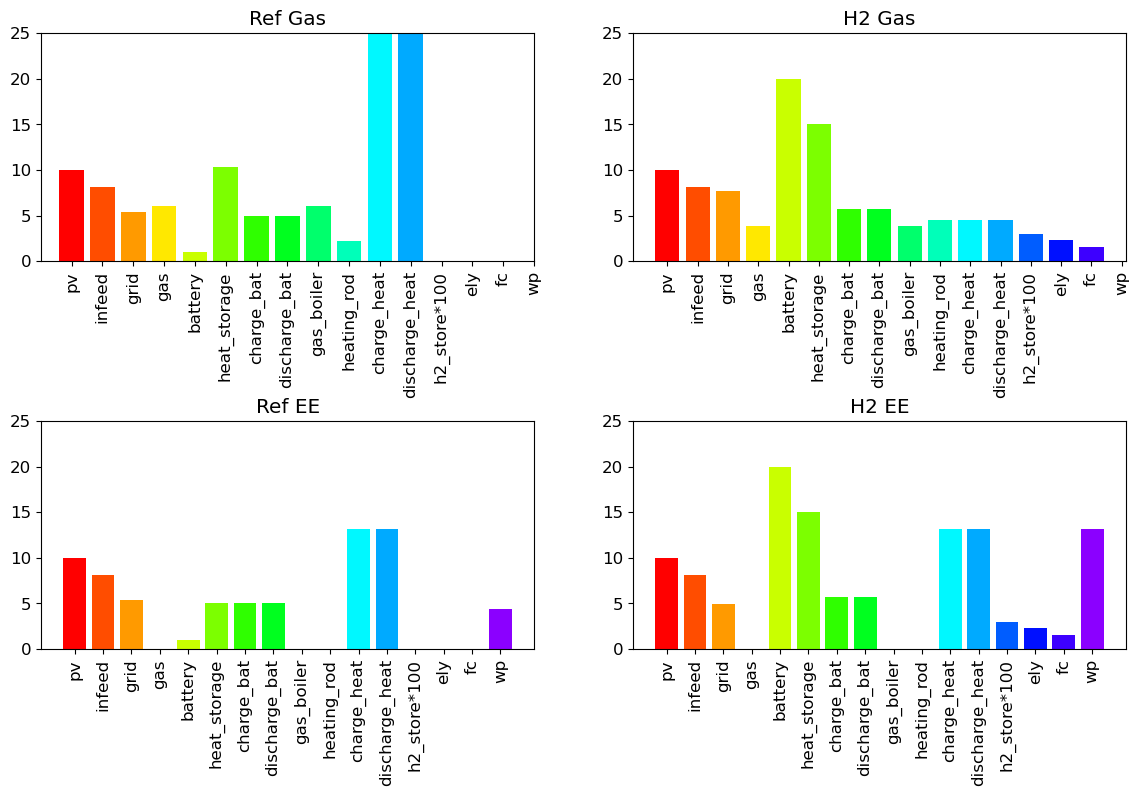

In [29]:
plot_opt_data(opt_value_summary(n_rg_4, n_hg_4, n_ree_4, n_hee_4, n_all=True))

C:\Users\Marvin\AppData\Local\Temp\ipykernel_38296\989162125.py:7: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



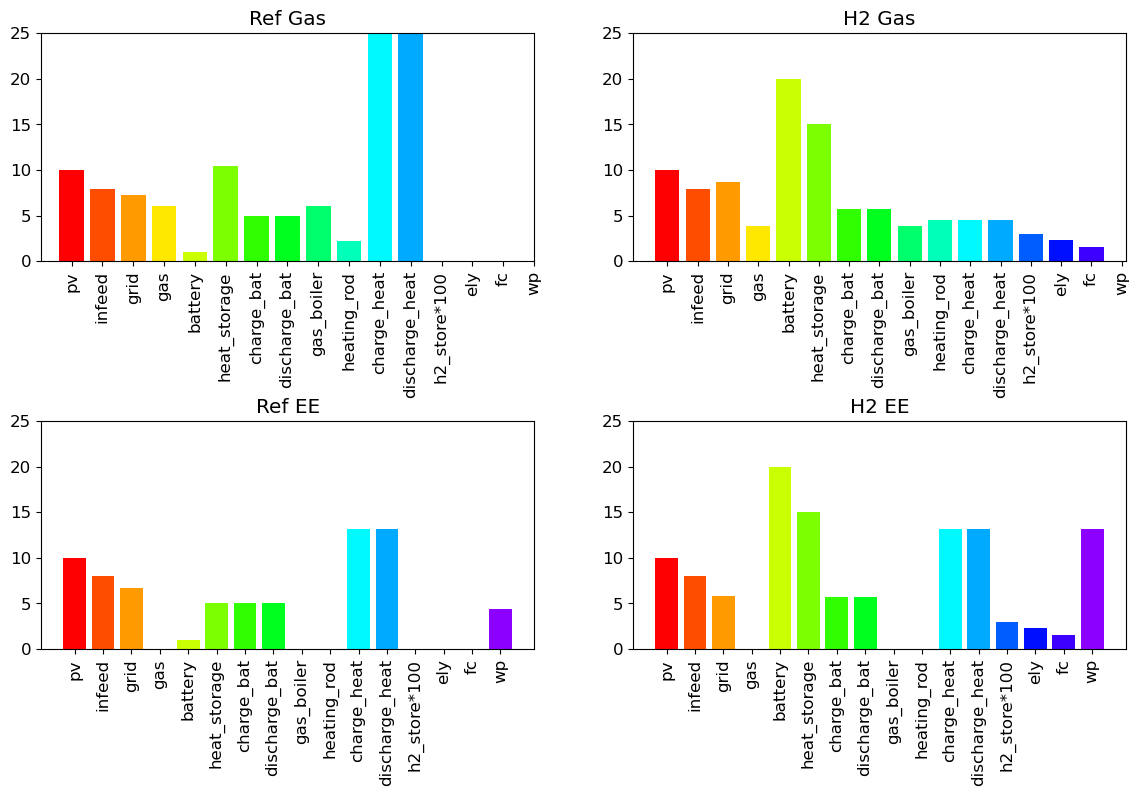

In [30]:
plot_opt_data(opt_value_summary(n_rg_6, n_hg_6, n_ree_6, n_hee_6, n_all=True))

CO2-Emissionen:  6315.079150018473


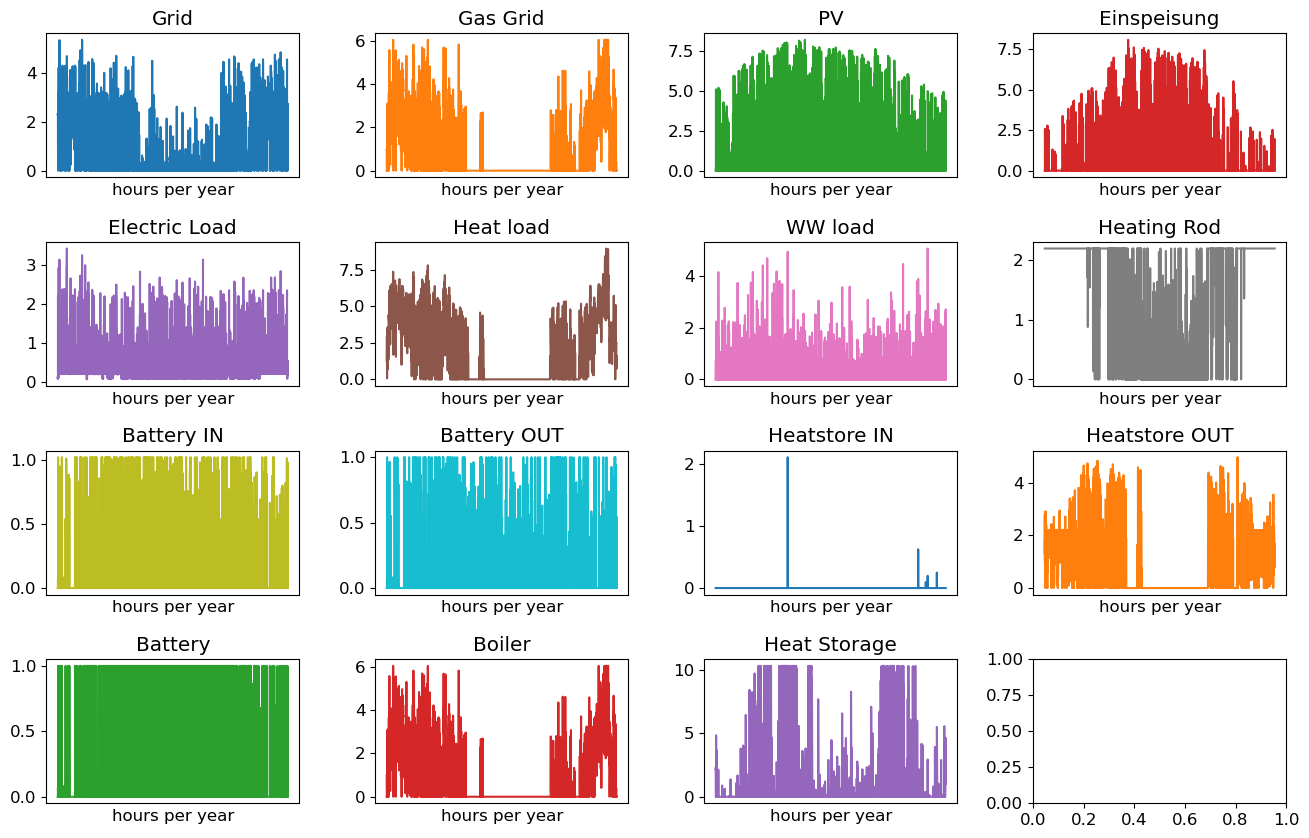

In [31]:
plot_series_data(opt_series_summary(n_rg_4, ref_gas=True))

CO2-Emissionen:  7097.815598552781


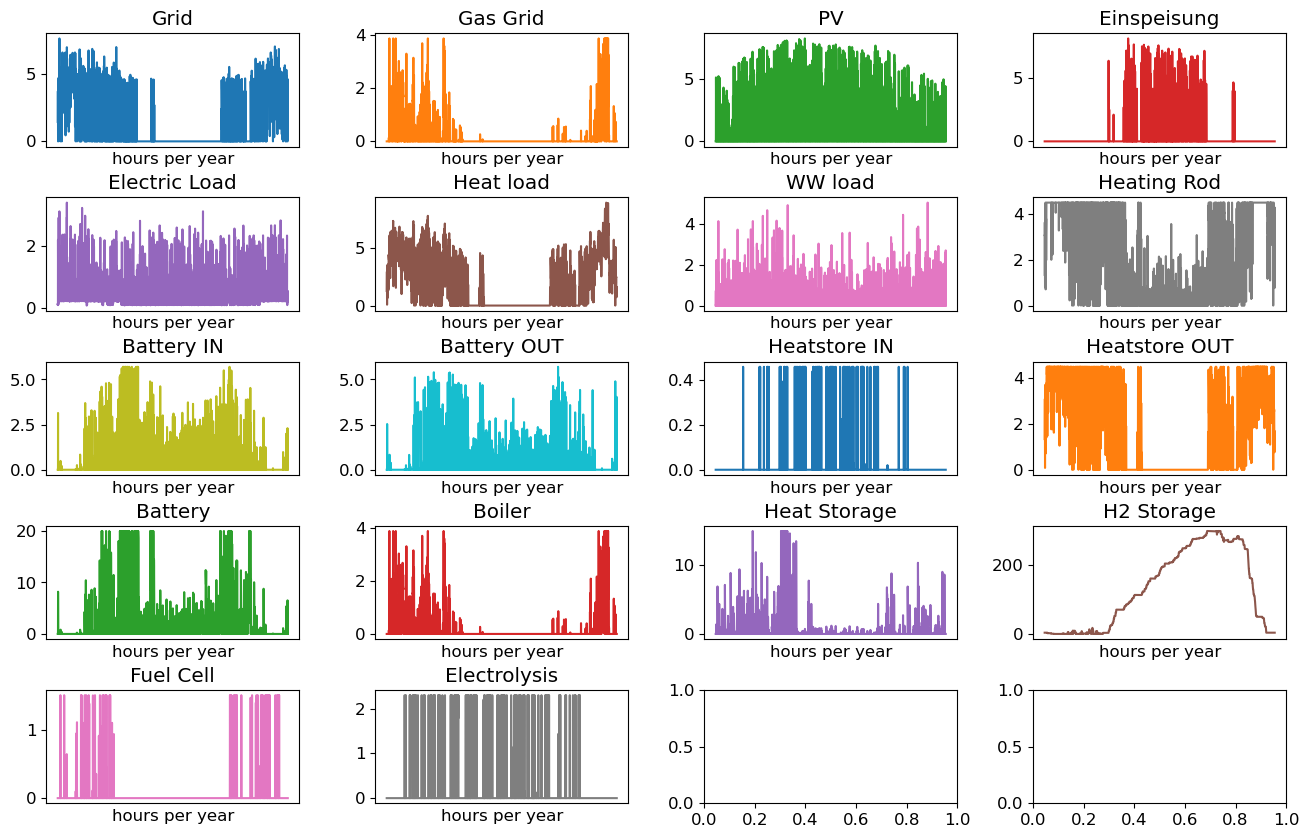

In [32]:
plot_series_data(opt_series_summary(n_hg_4, h2_gas=True))

CO2-Emissionen:  7072.319194288354


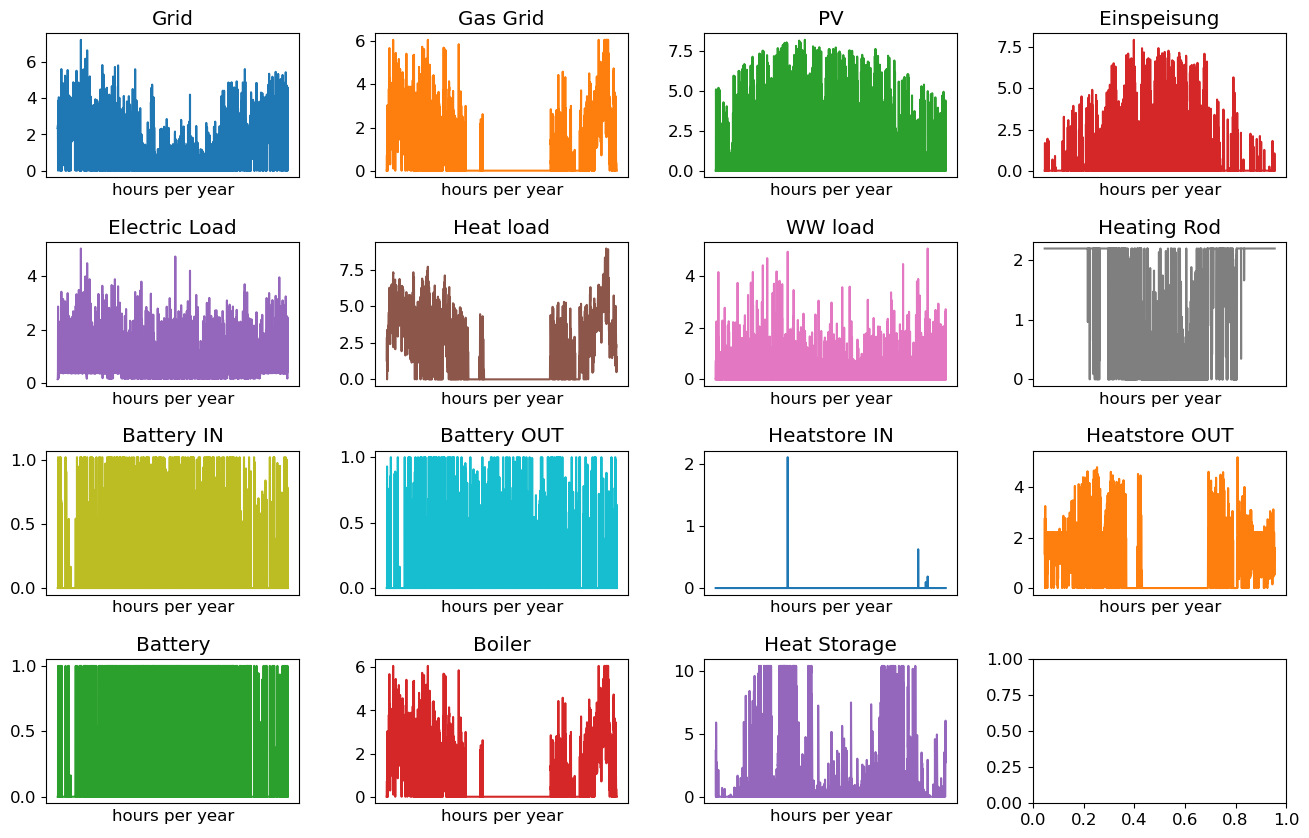

In [33]:
plot_series_data(opt_series_summary(n_rg_6, ref_gas=True))

CO2-Emissionen:  7821.885572729764


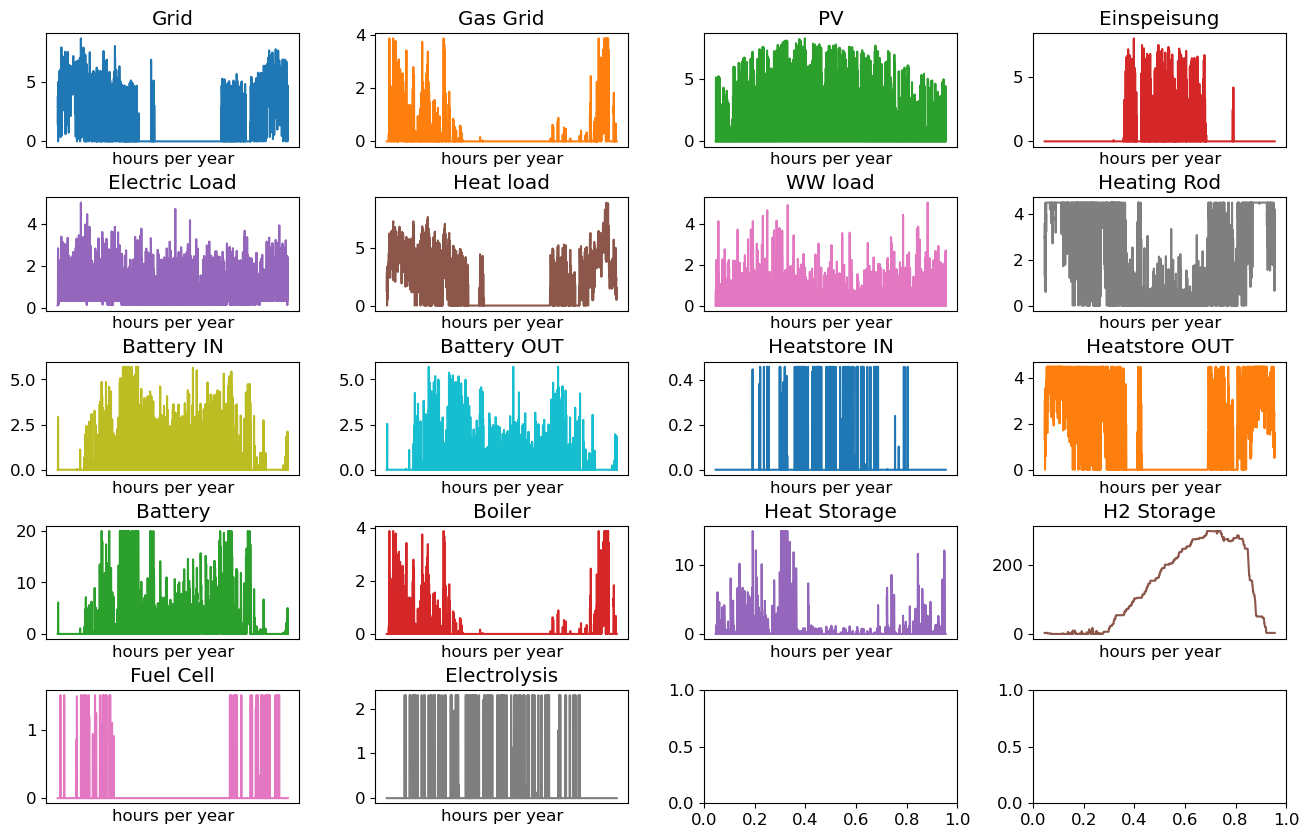

In [34]:
plot_series_data(opt_series_summary(n_hg_6, h2_gas=True))

In [35]:
# PV Threshhold runter setzen von 0.55 auf 0.4 - Vergleich von EE Netzwerken
pv_thresh = 0.4
df_season['ely_pv_threshhold'] = df_data['pv'].apply(lambda x: 1 if x >= pv_thresh else 0)

n_rg_4th = build_ref_network_gas(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'],ww_load=df_data['ww_load_4p'])
n_hg_4th = build_h2_network_gas(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'],ww_load=df_data['ww_load_4p'])
n_r_4th = build_ref_network(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'],ww_load=df_data['ww_load_4p'])
n_h_4th = build_h2_network(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'],ww_load=df_data['ww_load_4p'])

n_rg_4th.optimize(solver_name='gurobi')
n_hg_4th.optimize(solver_name='gurobi')
n_r_4th.optimize(solver_name='gurobi')
n_h_4th.optimize(solver_name='gurobi')

df_thresh_test = pd.concat([calc_global_results(n1=n_rg_4th, n2=n_hg_4th, n3=n_r_4th, n4=n_h_4th, n_all=True),
                           calc_global_results(n1=n_rg_4th, n2=n_hg_4th, n3=n_r_4th, n4=n_h_4th, n_all=True)], axis=0)
print("Comparation changes from PV Threshhold: row1-4:0.55; row5-8: new Threshhold")
df_thresh_test

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 27.27it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-9wmmgn9o.lp
Reading time = 0.42 seconds
obj: 271573 rows, 122649 columns, 516852 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 271573 rows, 122649 columns and 516852 nonzeros
Model fingerprint: 0x846c4c46
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [8e-02, 5e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 201550 rows and 35159 columns
Presolve time: 0.17s
Presolved: 70023 rows, 87490 columns, 218715 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 122649 primals, 271573 duals
Objective: 5.16e+04
Solver model: available
Solver message: 2

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 22.15it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-09h120ps.lp
Reading time = 0.54 seconds
obj: 341653 rows, 157688 columns, 648252 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 341653 rows, 157688 columns and 648252 nonzeros
Model fingerprint: 0xfa575578
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [8e-02, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 281126 rows and 65387 columns
Presolve time: 0.23s
Presolved: 60527 rows, 92301 columns, 240183 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157688 primals, 341653 duals
Objective: 3.98e+04
Solver model: available
Solver message: 2

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 31.76it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-92wtfdb0.lp
Reading time = 0.35 seconds
obj: 227770 rows, 105127 columns, 429249 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 227770 rows, 105127 columns and 429249 nonzeros
Model fingerprint: 0xa49a9b32
Coefficient statistics:
  Matrix range     [4e-01, 4e+00]
  Objective range  [8e-02, 2e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 166450 rows and 26284 columns
Presolve time: 0.15s
Presolved: 61320 rows, 78843 columns, 192720 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105127 primals, 227770 duals
Objective: 9.94e+03
Solver model: available
Solver message: 2

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 22.94it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-kms7l9k7.lp
Reading time = 0.48 seconds
obj: 297848 rows, 140165 columns, 551887 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 297848 rows, 140165 columns and 551887 nonzeros
Model fingerprint: 0xf5c85c9e
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [8e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 253321 rows and 55106 columns
Presolve time: 0.22s
Presolved: 44527 rows, 85059 columns, 199423 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140165 primals, 297848 duals
Objective: 2.29e+04
Solver model: available
Solver message: 2



Comparation changes from PV Threshhold: row1-4:0.55; row5-8: new Threshhold


,Network,Grid Supply [kWh/a],Total Load [kWh/a],Self Sufficiency [%],Total Emission [kg CO2/a],CAPEX [€],OPEX [€],Revenues Infeed [€/a],Revenues Savings [€/a],Payback Period [a]
0,Ref_Gas,19444.0,23902.0,18.65,6430.0,20581.05,48972.69,-430.27,0.00,48.0
1,H2_Gas,18156.0,23902.0,24.04,7371.0,105049.47,17690.07,-269.61,1049.34,-135.0
2,Ref_EE,7216.0,23902.0,69.81,3132.0,25121.78,2886.30,-564.53,0.00,45.0
3,H2_EE,4934.0,23902.0,79.36,2142.0,123965.00,1973.79,-362.34,-912.50,97.0
0,Ref_Gas,19444.0,23902.0,18.65,6430.0,20581.05,48972.69,-430.27,0.00,48.0
1,H2_Gas,18156.0,23902.0,24.04,7371.0,105049.47,17690.07,-269.61,1049.34,-135.0
2,Ref_EE,7216.0,23902.0,69.81,3132.0,25121.78,2886.30,-564.53,0.00,45.0
3,H2_EE,4934.0,23902.0,79.36,2142.0,123965.00,1973.79,-362.34,-912.50,97.0


C:\Users\Marvin\AppData\Local\Temp\ipykernel_38296\989162125.py:7: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



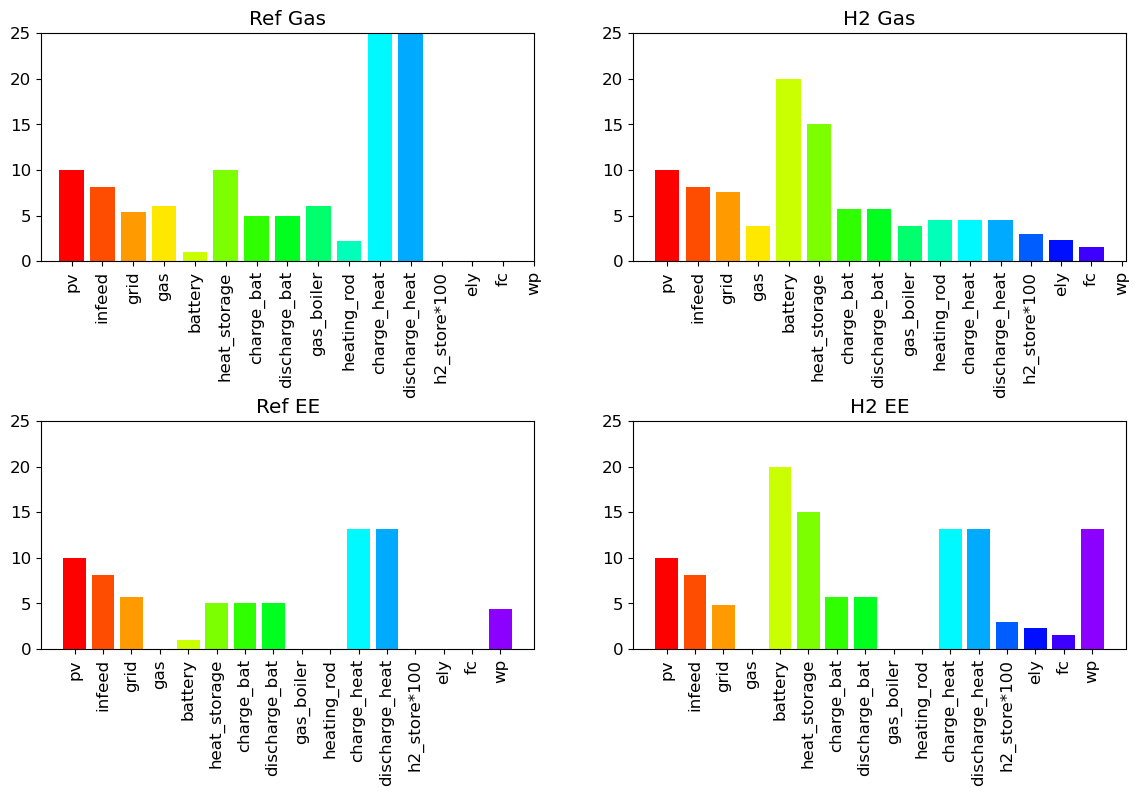

In [36]:
plot_opt_data(opt_value_summary(n1=n_rg_4th, n2=n_hg_4th, n3=n_r_4th, n4=n_h_4th, n_all=True))

C:\Users\Marvin\AppData\Local\Temp\ipykernel_38296\989162125.py:7: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



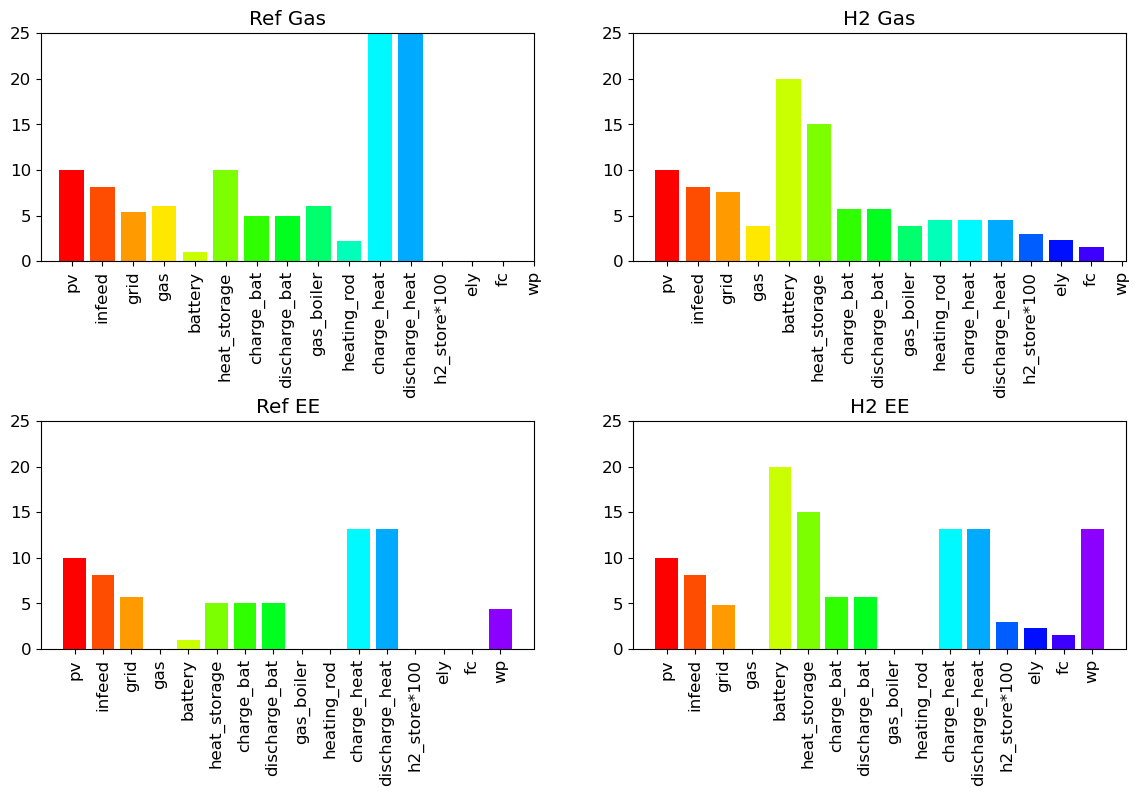

In [37]:
plot_opt_data(opt_value_summary(n1=n_rg_4th, n2=n_hg_4th, n3=n_r_4th, n4=n_h_4th, n_all=True))

CO2-Emissionen:  3131.633538606805


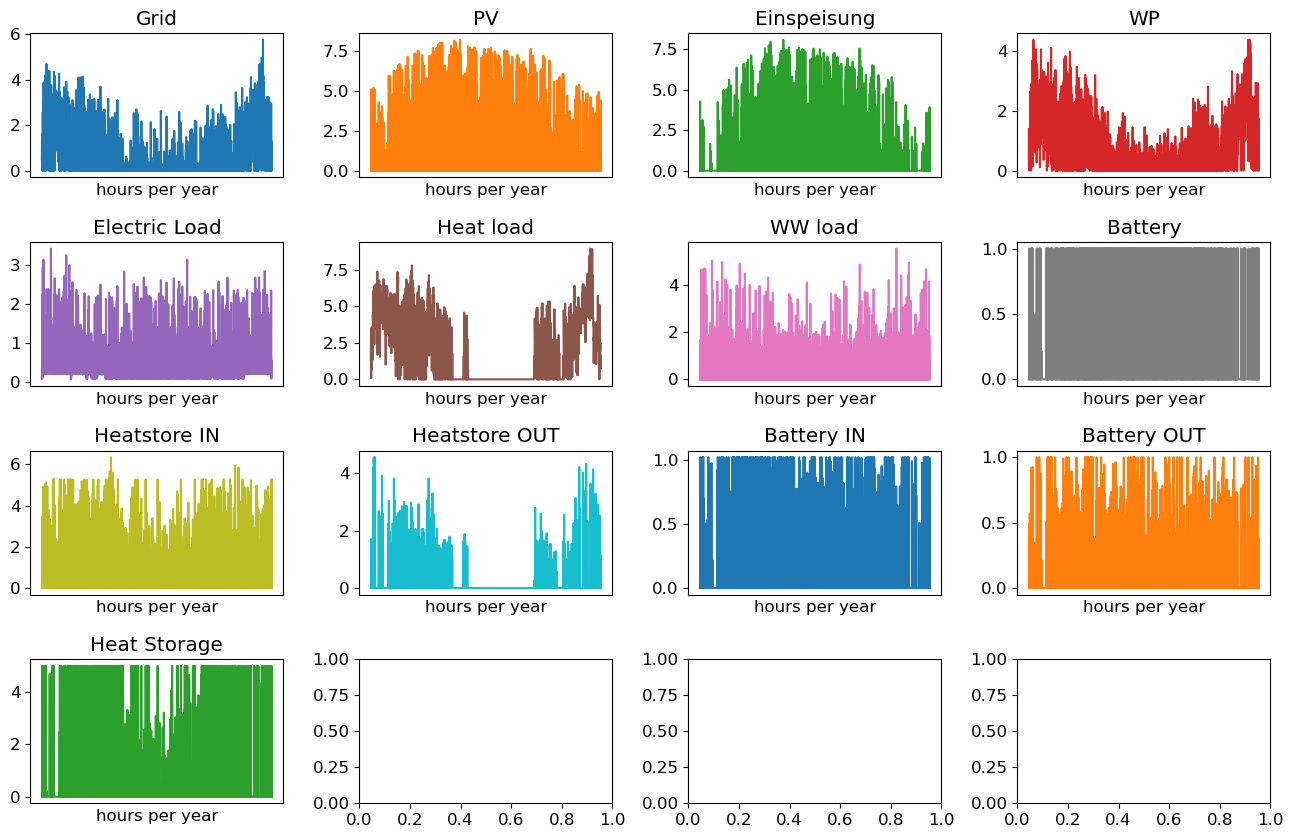

In [38]:
plot_series_data(opt_series_summary(n_r_4th, ref=True))

CO2-Emissionen:  2141.566108259471


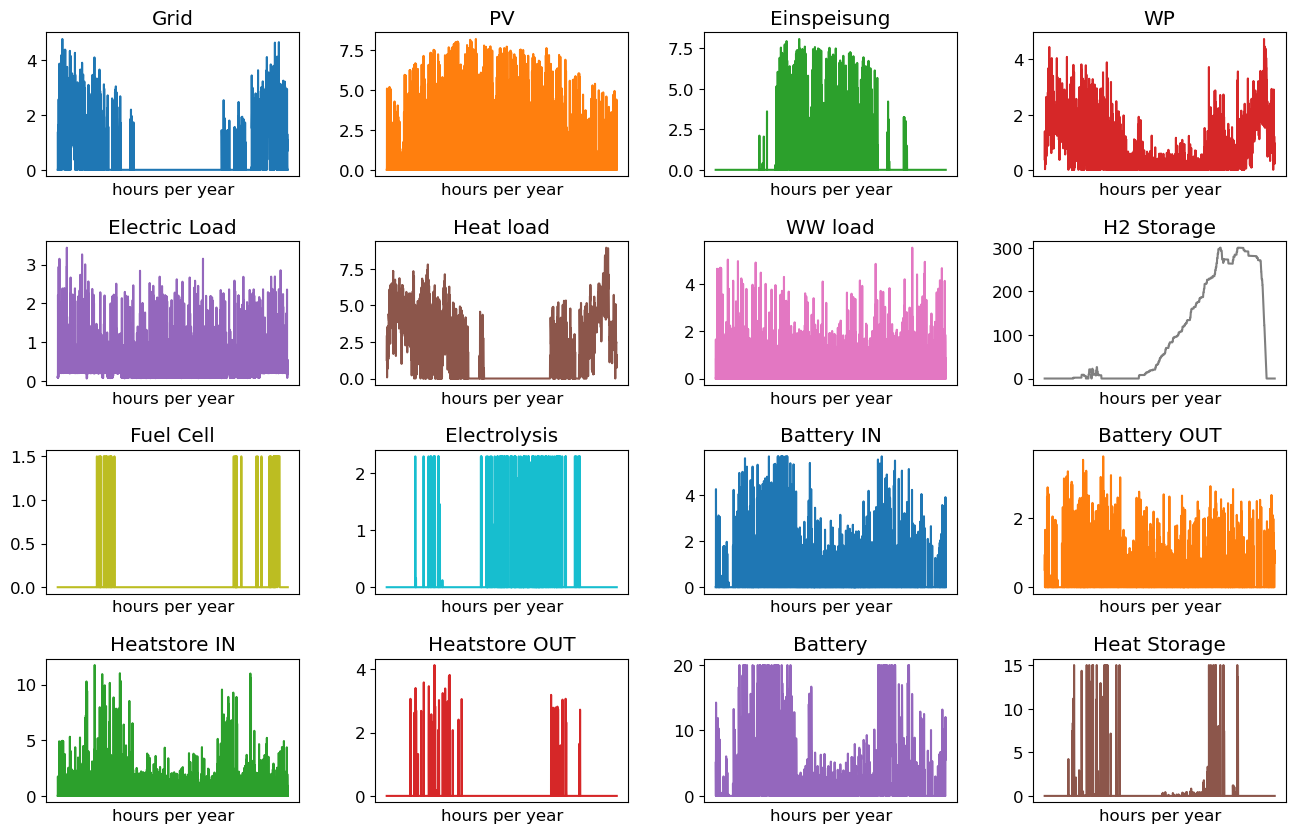

In [39]:
plot_series_data(opt_series_summary(n_h_4th, h2=True))

In [40]:
# CO2 Sensitivity 2-4-6 people households
# pv-thresh zurücksetzen
pv_thresh = 0.55
df_season['ely_pv_threshhold'] = df_data['pv'].apply(lambda x: 1 if x >= pv_thresh else 0)
opt_value_dict = {}

# Ref Networks
nc_rg_4 = build_ref_network_gas(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'],ww_load=df_data['ww_load_4p'])
nc_r_4 = build_ref_network(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'],ww_load=df_data['ww_load_4p'])
nc_rg_4.optimize(solver_name='gurobi')
nc_r_4.optimize(solver_name='gurobi')

co2_base_rg_4 = (nc_rg_4.generators_t.p.sum() / nc_rg_4.generators.efficiency *
                 pd.merge(nc_rg_4.carriers, nc_rg_4.generators.carrier, 
                          left_index = True, 
                          right_on = 'carrier')['co2_emissions']).sum() 
co2_base_r_4 = (nc_r_4.generators_t.p.sum() / nc_r_4.generators.efficiency *
                 pd.merge(nc_r_4.carriers, nc_r_4.generators.carrier, 
                          left_index = True, 
                          right_on = 'carrier')['co2_emissions']).sum() 

# H2 Networks
nc_hg_4 = build_h2_network_gas(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'], ww_load=df_data['ww_load_4p'])
nc_h_4 = build_h2_network(electric_load=df_data['e_load_4p'], heat_load=df_data['h_load_4p'], ww_load=df_data['ww_load_4p'])

nc_hg_4.optimize(solver_name='gurobi')
nc_h_4.optimize(solver_name='gurobi')
results_co2 = calc_global_results(n1=nc_rg_4, n2=nc_hg_4, n3=nc_r_4, n4=nc_h_4, n_all=True)

for co2_limit in np.arange(1, 0.4, -0.25):
    print('Gas-Network {}%:'.format(co2_limit*100), co2_limit * co2_base_rg_4, '\nEE-Network {}%:'.format(co2_limit*100), co2_limit * co2_base_r_4)
    
    nc_hg_4.global_constraints.loc['co2-limit', 'constant'] = (co2_limit * co2_base_rg_4)
    nc_h_4.global_constraints.loc['co2-limit', 'constant'] = (co2_limit * co2_base_r_4)
    
    nc_hg_4.optimize(solver_name='gurobi')
    nc_h_4.optimize(solver_name='gurobi')
    results_co2 = pd.concat([results_co2, calc_global_results(n1=nc_rg_4, n2=nc_hg_4, n3=nc_r_4, n4=nc_h_4, n_all=True)], axis=0)
    opt_value_dict[str(np.round(co2_limit*100, 0))] = opt_value_summary(n1=nc_rg_4, n2=nc_hg_4, n3=nc_r_4, n4=nc_h_4, n_all=True)


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 28.65it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-o5cslm5h.lp
Reading time = 0.42 seconds
obj: 271573 rows, 122649 columns, 516852 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 271573 rows, 122649 columns and 516852 nonzeros
Model fingerprint: 0x846c4c46
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [8e-02, 5e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 201550 rows and 35159 columns
Presolve time: 0.16s
Presolved: 70023 rows, 87490 columns, 218715 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 122649 primals, 271573 duals
Objective: 5.16e+04
Solver model: available
Solver message: 2

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 32.48it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-1mxbbkqg.lp
Reading time = 0.35 seconds
obj: 227770 rows, 105127 columns, 429249 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 227770 rows, 105127 columns and 429249 nonzeros
Model fingerprint: 0xa49a9b32
Coefficient statistics:
  Matrix range     [4e-01, 4e+00]
  Objective range  [8e-02, 2e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 166450 rows and 26284 columns
Presolve time: 0.14s
Presolved: 61320 rows, 78843 columns, 192720 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 105127 primals, 227770 duals
Objective: 9.94e+03
Solver model: available
Solver message: 2

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 22.30it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-ki83e55g.lp
Reading time = 0.54 seconds
obj: 341653 rows, 157688 columns, 648252 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 341653 rows, 157688 columns and 648252 nonzeros
Model fingerprint: 0xacced791
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [8e-02, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 281344 rows and 66122 columns
Presolve time: 0.25s
Presolved: 60309 rows, 91566 columns, 238718 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157688 primals, 341653 duals
Objective: 4.01e+04
Solver model: available
Solver message: 2

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 24.06it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-sz3vbmfl.lp
Reading time = 0.46 seconds
obj: 297848 rows, 140165 columns, 551887 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 297848 rows, 140165 columns and 551887 nonzeros
Model fingerprint: 0xd4bbd47b
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [8e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 1e+100]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 253529 rows and 55831 columns
Presolve time: 0.21s
Presolved: 44319 rows, 84334 columns, 197978 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140165 primals, 297848 duals
Objective: 2.29e+04
Solver model: available
Solver message: 2



Gas-Network 100.0%: 6430.191148451598 
EE-Network 100.0%: 3131.633538606805


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 21.34it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-pqgnjnc0.lp
Reading time = 0.53 seconds
obj: 341653 rows, 157688 columns, 648252 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 341653 rows, 157688 columns and 648252 nonzeros
Model fingerprint: 0x0c4b358f
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [8e-02, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 6e+03]
Presolve removed 281343 rows and 66122 columns
Presolve time: 0.24s
Presolved: 60310 rows, 91566 columns, 259103 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 7
 AA' NZ     : 3.139e+05
 Factor NZ  : 1.025e+06 (roughly 70 MB of memory

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157688 primals, 341653 duals
Objective: 5.11e+04
Solver model: available
Solver message: 2

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 22.93it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-jifl0tlv.lp
Reading time = 0.48 seconds
obj: 297848 rows, 140165 columns, 551887 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 297848 rows, 140165 columns and 551887 nonzeros
Model fingerprint: 0x11b1db3d
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [8e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 3e+03]
Presolve removed 253528 rows and 55831 columns
Presolve time: 0.23s
Presolved: 44320 rows, 84334 columns, 206738 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.01s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.330e+05
 Factor NZ  : 7.245e+05 (roughly 60 MB of memory

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140165 primals, 297848 duals
Objective: 2.29e+04
Solver model: available
Solver message: 2



Gas-Network 75.0%: 4822.643361338698 
EE-Network 75.0%: 2348.7251539551035


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 20.75it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-ugxncror.lp
Reading time = 0.57 seconds
obj: 341653 rows, 157688 columns, 648252 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 341653 rows, 157688 columns and 648252 nonzeros
Model fingerprint: 0xd4ec32d4
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [8e-02, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 5e+03]
Presolve removed 281343 rows and 66122 columns
Presolve time: 0.30s
Presolved: 60310 rows, 91566 columns, 259103 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 7
 AA' NZ     : 3.139e+05
 Factor NZ  : 1.025e+06 (roughly 70 MB of memory

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157688 primals, 341653 duals
Objective: 7.67e+04
Solver model: available
Solver message: 2

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 23.08it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-r41k7kjx.lp
Reading time = 0.48 seconds
obj: 297848 rows, 140165 columns, 551887 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 297848 rows, 140165 columns and 551887 nonzeros
Model fingerprint: 0x6a9ae334
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [8e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 2e+03]
Presolve removed 253528 rows and 55831 columns
Presolve time: 0.25s
Presolved: 44320 rows, 84334 columns, 206738 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.330e+05
 Factor NZ  : 7.245e+05 (roughly 60 MB of memory

INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 140165 primals, 297848 duals
Objective: 2.29e+04
Solver model: available
Solver message: 2



Gas-Network 50.0%: 3215.095574225799 
EE-Network 50.0%: 1565.8167693034025


INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 21.31it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-fqp6j38c.lp
Reading time = 0.56 seconds
obj: 341653 rows, 157688 columns, 648252 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 341653 rows, 157688 columns and 648252 nonzeros
Model fingerprint: 0xc0694da5
Coefficient statistics:
  Matrix range     [2e-01, 1e+00]
  Objective range  [8e-02, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 3e+03]
Presolve removed 281343 rows and 66122 columns
Presolve time: 0.30s
Presolved: 60310 rows, 91566 columns, 259103 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.03s

Barrier statistics:
 Dense cols : 7
 AA' NZ     : 3.139e+05
 Factor NZ  : 1.025e+06 (roughly 70 MB of memory


Solved with barrier
   16386    1.0334438e+05   0.000000e+00   0.000000e+00      4s

Solved in 16386 iterations and 4.22 seconds (3.46 work units)
Optimal objective  1.033443764e+05


INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 157688 primals, 341653 duals
Objective: 1.03e+05
Solver model: available
Solver message: 2

INFO:linopy.model: Solve linear problem using Gurobi solver
Writing continuous variables.: 100%|██████████| 7/7 [00:00<00:00, 24.35it/s]


Read LP format model from file C:\Users\Marvin\AppData\Local\Temp\linopy-problem-x8g61fp0.lp
Reading time = 0.46 seconds
obj: 297848 rows, 140165 columns, 551887 nonzeros
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: AMD Ryzen 7 5800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 297848 rows, 140165 columns and 551887 nonzeros
Model fingerprint: 0x894bb725
Coefficient statistics:
  Matrix range     [2e-01, 4e+00]
  Objective range  [8e-02, 7e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e-03, 2e+03]
Presolve removed 253528 rows and 55831 columns
Presolve time: 0.23s
Presolved: 44320 rows, 84334 columns, 206738 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...

Ordering time: 0.02s

Barrier statistics:
 Dense cols : 8
 AA' NZ     : 2.330e+05
 Factor NZ  : 7.245e+05 (roughly 60 MB of memory

Status: warning
Termination condition: infeasible_or_unbounded
Solution: 0 primals, 0 duals
Objective: nan
Solver model: available
Solver message: 4



In [41]:
# result dataframes
index_lst = list(np.round(np.flip(np.arange(0.5, 1.26, 0.25))*100,0))
h2gas = results_co2[results_co2["Network"] == 'H2_Gas']
h2gas["co2-limit [%]"] = index_lst
h2gas.set_index(h2gas["co2-limit [%]"], inplace=True)
h2gas.drop(columns=["co2-limit [%]"], axis=0, inplace=True)


h2ee = results_co2[results_co2["Network"] == 'H2_EE']
h2ee["co2-limit [%]"] = index_lst
h2ee.set_index(h2ee["co2-limit [%]"], inplace=True)
h2ee.drop(columns=["co2-limit [%]"], axis=0, inplace=True)

# h2gas

h2gas

C:\Users\Marvin\AppData\Local\Temp\ipykernel_38296\3195651843.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Marvin\AppData\Local\Temp\ipykernel_38296\3195651843.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Marvin\AppData\Local\Temp\ipykernel_38296\3195651843.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

,Network,Grid Supply [kWh/a],Total Load [kWh/a],Self Sufficiency [%],Total Emission [kg CO2/a],CAPEX [€],OPEX [€],Revenues Infeed [€/a],Revenues Savings [€/a],Payback Period [a]
co2-limit [%],,,,,,,,,,
125.0,H2_Gas,18104.0,23902.0,24.26,7331.0,105049.47,18036.31,-269.01,1010.26,-142.0
100.0,H2_Gas,17304.0,23902.0,27.61,6430.0,105049.47,29064.17,-265.19,112.82,689.0
75.0,H2_Gas,16503.0,23902.0,30.95,4823.0,105049.47,54587.91,-265.19,-1521.83,59.0
50.0,H2_Gas,15769.0,23902.0,34.03,3215.0,105602.34,80721.92,-264.89,-3159.94,31.0


<Axes: >

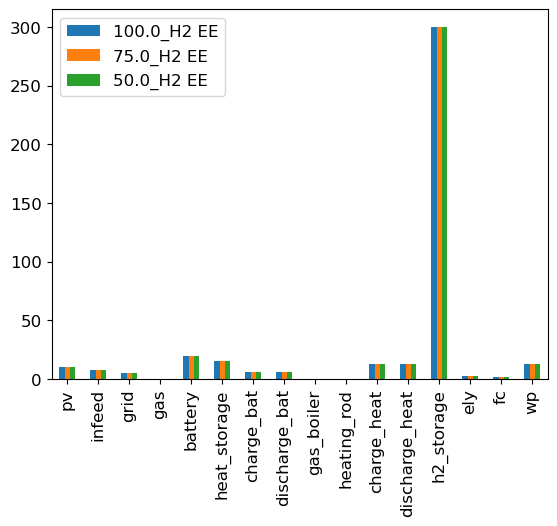

In [42]:
# optimierungswerte
dfcg_opt = pd.DataFrame()
dfcee_opt = pd.DataFrame()

for key, val in opt_value_dict.items():
    dfcg_opt[str(key + "_" + val.columns[1])] = val[val.columns[1]]
    dfcee_opt[str(key + "_" + val.columns[3])] = val[val.columns[3]]

# dfcg_opt
dfcee_opt.plot(kind='bar')

In [43]:
#ALT co2 SENSITIVITÄTSTEST
'''
#n_ref = build_ref_network()

n_ref.global_constraints.loc['co2-limit', 'constant'] = np.inf #höchste CO2 Emissionen setzen
n_ref.optimize(solver_name='gurobi')

#n_h2 = build_h2_network()
#n_ref.optimize(solver_name='gurobi')

results_ref = auswertungsfunktion(n_ref,100,0)
basis_co2_emissions = results_ref['CO2_emissions in kg/a'].values #TODO: als Referenzdaten für CO2-Emissionen doch die vom Referenzmodell einsetzen


#results_ref = pd.DataFrame(auswertungsfunktion(n_ref,100,0))
#basis_co2_emissions = results_ref['CO2_emissions in kg/a'].values #TODO: als Referenzdaten für CO2-Emissionen doch die vom Referenzmodell einsetzen

for co2_limit in np.flip(np.arange(0.7, 1, 0.10)):
    print(co2_limit* basis_co2_emissions)
    n_ref.global_constraints.loc['co2-limit', 'constant'] = (co2_limit * basis_co2_emissions)
    n_ref.optimize(solver_name='gurobi')
    results_ref = results_ref.append(auswertungsfunktion(n_ref, co2_limit * 100))
    '''

"\n#n_ref = build_ref_network()\n\nn_ref.global_constraints.loc['co2-limit', 'constant'] = np.inf #höchste CO2 Emissionen setzen\nn_ref.optimize(solver_name='gurobi')\n\n#n_h2 = build_h2_network()\n#n_ref.optimize(solver_name='gurobi')\n\nresults_ref = auswertungsfunktion(n_ref,100,0)\nbasis_co2_emissions = results_ref['CO2_emissions in kg/a'].values #TODO: als Referenzdaten für CO2-Emissionen doch die vom Referenzmodell einsetzen\n\n\n#results_ref = pd.DataFrame(auswertungsfunktion(n_ref,100,0))\n#basis_co2_emissions = results_ref['CO2_emissions in kg/a'].values #TODO: als Referenzdaten für CO2-Emissionen doch die vom Referenzmodell einsetzen\n\nfor co2_limit in np.flip(np.arange(0.7, 1, 0.10)):\n    print(co2_limit* basis_co2_emissions)\n    n_ref.global_constraints.loc['co2-limit', 'constant'] = (co2_limit * basis_co2_emissions)\n    n_ref.optimize(solver_name='gurobi')\n    results_ref = results_ref.append(auswertungsfunktion(n_ref, co2_limit * 100))\n    "

In [44]:
#ALT co2 SENSITIVITÄTSTEST

'''
n_h2.global_constraints.loc['co2-limit', 'constant'] = np.inf #höchste CO2 Emissionen setzen

#Iterationen
#n_ref = build_ref_network()
#n_h2 = build_h2_network()
n_h2.optimize(solver_name='gurobi')
#results_ref = pd.DataFrame()
#results_h2 = pd.DataFrame()
results_h2 = pd.DataFrame(auswertungsfunktion(n_h2,100,0))
basis_co2_emissions = results_h2['CO2_emissions in kg/a'].values #TODO: als Referenzdaten für CO2-Emissionen doch die vom Referenzmodell einsetzen


for co2_limit in np.flip(np.arange(0.5, 1, 0.2)):
    print(co2_limit* basis_co2_emissions)
    n_h2.global_constraints.loc['co2-limit', 'constant'] = (co2_limit * basis_co2_emissions)
    n_h2.optimize(solver_name='gurobi')
    results_h2 = results_h2.append(auswertungsfunktion(n_h2, co2_limit * 100))
  

for strompreis_bezug in np.flip(np.arange(0.28, 1.48, 0.4)): 
    print(strompreis_bezug)
    n_ref.generators.loc['grid', 'marginal_cost'] = strompreis_bezug
    n_h2.generators.loc['grid', 'marginal_cost'] = strompreis_bezug
    n_ref.optimize(solver_name = 'gurobi')
    n_h2.optimize(solver_name='gurobi')
    n_h2.stores.loc['battery', 'e_nom'] = n_ref.stores.e_nom_opt.battery
    n_h2.stores.loc['heat_storage', 'e_nom'] = n_ref.stores.e_nom_opt.heat_storage
    
    results_h2 = results_h2.append(auswertungsfunktion(n_h2, strompreis_bezug))
    results_ref = results_ref.append(auswertungsfunktion(n_ref, strompreis_bezug))
'''


"\nn_h2.global_constraints.loc['co2-limit', 'constant'] = np.inf #höchste CO2 Emissionen setzen\n\n#Iterationen\n#n_ref = build_ref_network()\n#n_h2 = build_h2_network()\nn_h2.optimize(solver_name='gurobi')\n#results_ref = pd.DataFrame()\n#results_h2 = pd.DataFrame()\nresults_h2 = pd.DataFrame(auswertungsfunktion(n_h2,100,0))\nbasis_co2_emissions = results_h2['CO2_emissions in kg/a'].values #TODO: als Referenzdaten für CO2-Emissionen doch die vom Referenzmodell einsetzen\n\n\nfor co2_limit in np.flip(np.arange(0.5, 1, 0.2)):\n    print(co2_limit* basis_co2_emissions)\n    n_h2.global_constraints.loc['co2-limit', 'constant'] = (co2_limit * basis_co2_emissions)\n    n_h2.optimize(solver_name='gurobi')\n    results_h2 = results_h2.append(auswertungsfunktion(n_h2, co2_limit * 100))\n  \n\nfor strompreis_bezug in np.flip(np.arange(0.28, 1.48, 0.4)): \n    print(strompreis_bezug)\n    n_ref.generators.loc['grid', 'marginal_cost'] = strompreis_bezug\n    n_h2.generators.loc['grid', 'marginal_

In [45]:
#ALT!!! - Test mit statischem Preis (1) und Preisprofil (2)
'''
# setup reference networks
n_ref1 = build_ref_network()

n_ref2 = build_ref_network()
n_ref2.generators_t.marginal_cost.grid = df_price_data["2021"]
# optimize
n_ref1.optimize(solver_name='gurobi')
n_ref2.optimize(solver_name='gurobi')

# setup h2 networks
n_hy1 = build_h2_network()
#n_hy1.stores.e_nom.battery = n_ref1.stores.e_nom_opt.battery
n_hy1.stores.e_nom.heat_storage = n_ref1.stores.e_nom_opt.heat_storage
n_hy1.links.p_nom.wp = n_ref1.links.p_nom_opt.wp
#n_hy1.links_t.p_max_pu.ely = df_season["ely"]
#n_hy1.links_t.p_max_pu.fc = df_season["fc"]

n_hy2 = build_h2_network()
#n_hy2.stores.e_nom.battery = n_ref2.stores.e_nom_opt.battery
n_hy2.stores.e_nom.heat_storage = n_ref2.stores.e_nom_opt.heat_storage
n_hy2.links.p_nom.wp = n_ref2.links.p_nom_opt.wp
n_hy2.links.p_nom_max.charge_heat = n_ref2.links.p_nom_opt.wp
n_hy2.links.p_nom_max.discharge_heat = n_ref2.links.p_nom_opt.wp
n_hy2.generators_t.marginal_cost.grid = df_price_data["2021"]
#n_hy2.links_t.p_max_pu.ely = df_season["ely"]
#n_hy2.links_t.p_max_pu.fc = df_season["fc"]

# optimize networks
n_hy1.optimize(solver_name='gurobi')
n_hy2.optimize(solver_name='gurobi')

ref1_data = opt_series_summary(n_ref1, ref=True)
ref2_data = opt_series_summary(n_ref2, ref=True)
hy1_data = opt_series_summary(n_hy1, h2=True)
hy2_data = opt_series_summary(n_hy2, h2=True)
'''

'\n# setup reference networks\nn_ref1 = build_ref_network()\n\nn_ref2 = build_ref_network()\nn_ref2.generators_t.marginal_cost.grid = df_price_data["2021"]\n# optimize\nn_ref1.optimize(solver_name=\'gurobi\')\nn_ref2.optimize(solver_name=\'gurobi\')\n\n# setup h2 networks\nn_hy1 = build_h2_network()\n#n_hy1.stores.e_nom.battery = n_ref1.stores.e_nom_opt.battery\nn_hy1.stores.e_nom.heat_storage = n_ref1.stores.e_nom_opt.heat_storage\nn_hy1.links.p_nom.wp = n_ref1.links.p_nom_opt.wp\n#n_hy1.links_t.p_max_pu.ely = df_season["ely"]\n#n_hy1.links_t.p_max_pu.fc = df_season["fc"]\n\nn_hy2 = build_h2_network()\n#n_hy2.stores.e_nom.battery = n_ref2.stores.e_nom_opt.battery\nn_hy2.stores.e_nom.heat_storage = n_ref2.stores.e_nom_opt.heat_storage\nn_hy2.links.p_nom.wp = n_ref2.links.p_nom_opt.wp\nn_hy2.links.p_nom_max.charge_heat = n_ref2.links.p_nom_opt.wp\nn_hy2.links.p_nom_max.discharge_heat = n_ref2.links.p_nom_opt.wp\nn_hy2.generators_t.marginal_cost.grid = df_price_data["2021"]\n#n_hy2.links

In [46]:
#ALT!!! - Test mit statischem Preis (1) und Preisprofil (2)
'''
# setup reference networks
n_gas1 = build_ref_network_gas()

n_gas2 = build_ref_network_gas()
n_gas2.generators_t.marginal_cost.grid = df_price_data["2022"]
# optimize
n_gas1.optimize(solver_name='gurobi')
n_gas2.optimize(solver_name='gurobi')

# setup h2 networks
n_hy3 = build_h2_network()
#n_hy3.stores.e_nom.battery = n_gas1.stores.e_nom_opt.battery
n_hy3.stores.e_nom.heat_storage = n_gas1.stores.e_nom_opt.heat_storage

n_hy4 = build_h2_network()
#n_hy4.stores.e_nom.battery = n_gas2.stores.e_nom_opt.battery
n_hy4.stores.e_nom.heat_storage = n_gas2.stores.e_nom_opt.heat_storage
n_hy4.links.p_nom_max.charge_heat = n_gas2.links.p_nom_opt.gas_boiler
n_hy4.links.p_nom_max.discharge_heat = n_gas2.links.p_nom_opt.gas_boiler
n_hy4.generators_t.marginal_cost.grid = df_price_data["2022"]
#n_hy4.links_t.p_max_pu.ely = df_season["ely"]
#n_hy4.links_t.p_max_pu.fc = df_season["fc"]

# optimize networks
n_hy3.optimize(solver_name='gurobi')
n_hy4.optimize(solver_name='gurobi')

gas1_data = opt_series_summary(n_gas1, ref_gas=True)
gas2_data = opt_series_summary(n_gas2, ref_gas=True)
hy3_data = opt_series_summary(n_hy3, h2=True)
hy4_data = opt_series_summary(n_hy4, h2=True)
'''

'\n# setup reference networks\nn_gas1 = build_ref_network_gas()\n\nn_gas2 = build_ref_network_gas()\nn_gas2.generators_t.marginal_cost.grid = df_price_data["2022"]\n# optimize\nn_gas1.optimize(solver_name=\'gurobi\')\nn_gas2.optimize(solver_name=\'gurobi\')\n\n# setup h2 networks\nn_hy3 = build_h2_network()\n#n_hy3.stores.e_nom.battery = n_gas1.stores.e_nom_opt.battery\nn_hy3.stores.e_nom.heat_storage = n_gas1.stores.e_nom_opt.heat_storage\n\nn_hy4 = build_h2_network()\n#n_hy4.stores.e_nom.battery = n_gas2.stores.e_nom_opt.battery\nn_hy4.stores.e_nom.heat_storage = n_gas2.stores.e_nom_opt.heat_storage\nn_hy4.links.p_nom_max.charge_heat = n_gas2.links.p_nom_opt.gas_boiler\nn_hy4.links.p_nom_max.discharge_heat = n_gas2.links.p_nom_opt.gas_boiler\nn_hy4.generators_t.marginal_cost.grid = df_price_data["2022"]\n#n_hy4.links_t.p_max_pu.ely = df_season["ely"]\n#n_hy4.links_t.p_max_pu.fc = df_season["fc"]\n\n# optimize networks\nn_hy3.optimize(solver_name=\'gurobi\')\nn_hy4.optimize(solver_nam